<h1><center>Introduction to SPAM Filtering using Machine Learning!</center></h1>


<h2><center>Introduction</center></h2>
<p> We are going to classify emails into spam and non-spam categories. Due to the limited time frame we are considering only the email content to create a model for classification. When cereating advance model we can use email header information and other meta data to create a better models. </p>
<p> First we going to load the data and do some basic analysis. Then we will do some data cleaning and feature engineering. After that we will create a model and evaluate the model.  </p>

<h2><center>1. Install Libraries </center></h2>
<p> First , we need to install the required libraries. </p>


In [4]:
%pip install pandas scikit-learn numpy matplotlib seaborn nltk wordcloud xgboost lightgbm

<h2><center>2. Import Libraries </center></h2>

<p> Next thing is to import all the libraries that we are going to use in this project. </p>

- <b>numpy</b> : Numpy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
- <b>pandas</b> : Pandas is a software library written for the Python programming language for data manipulation and analysis.
- <b>matplotlib</b> : Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
- <b>seaborn</b> : Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- <b>sklearn</b> : Scikit-learn is a  machine learning library for the Python programming language
- <b>nltk</b> : NLTK is a leading platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.


In [5]:
# For data manipulation and analysis
import pandas as pd
import numpy as np
import string
from collections import Counter

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For text processing and feature extraction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# For text preprocessing and feature extraction
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize


# Machine learning models and evaluation metrics
from sklearn.naive_bayes import GaussianNB,MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier, XGBRFClassifier

# from sklearn.svm import SVC
from lightgbm.sklearn import LGBMClassifier

# Machine learning evaluation metrics
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,classification_report
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, recall_score

from wordcloud import WordCloud
import pickle

import warnings
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<center> <h2> 3. Data Loading and overview </h2> </center>

<h3> Data Loading </h3>

<p> next we are going to load the data. Our data is in csv fromat. We can use Pandas data frame to load the data.You can think of it like a spreadsheet or SQL table, or a dict of Series objects. Dataframe is a 2-dimensional labeled data structure with columns of potentially different types. ou can think of it like a spreadsheet or SQL table, or a dict of Series objects. It is generally the most commonly used pandas object. </p>

Pandas can read data directly from a URL. We are going to use this feature to load the data from the github URL. 



<p>After Loading the data set we can use head() function to see the first 5 rows of the data set.</P>

In [6]:
#Figure out a way to load data set when use google colab

data_url = "https://raw.githubusercontent.com/qualitia-cdev/jpaawg6th-handson-data/master/data/spam_dataset.csv"
# dataset = "./data/spam_dataset.csv"

df = pd.read_csv(data_url, encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Overview of the dataset
The dataset seems to contain multiple columns:

- v1: This appears to be the label, indicating whether a message is "spam" or "ham" (not spam).
- v2: This seems to be the text content of the message.
- Unnamed: 2, Unnamed: 3, and Unnamed: 4: These columns seem to contain mostly NaN (missing) values based on the initial view.

<center> <h2> 4. EDA (Exploratory Data Analysis) </h2> </center>

### What is EDA
EDA, or Exploratory Data Analysis, is the process of visually and analytically exploring a dataset to understand its main characteristics, uncover patterns, spot anomalies, test hypotheses, and check assumptions. It's a crucial step before formal modeling in the data analysis process.

In summary, 
- EDA is about getting to know your data—understanding its structure, outliers, patterns, and anomalies—before making more formal conclusions or building predictive models. It's like a preliminary investigation to guide the subsequent analysis.

To proceed with the exploratory data analysis (EDA):

- We'll check for the number of missing values in each column.
- Get a summary of the dataset, such as the number of spam vs. ham messages.
- Visualize the distribution of message lengths for both spam and ham messages.
  
Let's start by checking the missing values in each column.

In [7]:
len(df)

5572

In [8]:
# Check for missing values in each coslumn
missing_values = df.isnull().sum()
missing_values

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Given that the majority of the entries in the columns Unnamed: 2, Unnamed: 3, and Unnamed: 4 are missing, and they do not seem to contain essential information for our analysis, it might be best to drop these columns.

In [9]:
# last 3 columns are unnecessary. So we are going to drop them.
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

Also we are going to rename the columns for better understanding. 
We can see that v1 column includes the labels and v2 column includes the text content of the message. So we can rename the columns as label and text.

In [10]:
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Distribution of Target Variables
<p>For this dataset, <b>target variable</b> is <b>label column</b>.</p>
<p>We are going to see how the label column is distributed among the dataset.</p>
<p>Let's create pie chart using seabon library to see the distribution of the target variable.</p>

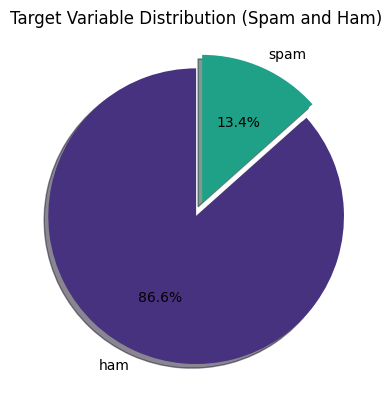

label
ham     4825
spam     747
Name: count, dtype: int64


In [11]:
target_cat = df.label.value_counts()

#create pie chart using seaborn
color1 = sns.color_palette("viridis")[0]
color2 = sns.color_palette("viridis")[3]

plt.pie(target_cat, labels=target_cat.index, colors=[color1, color2], autopct='%1.1f%%', shadow=True, startangle=90, explode=(0, 0.1))
plt.title('Target Variable Distribution (Spam and Ham)')
plt.show()

print(target_cat)

We can see that the dataset is imbalanced. There are 4825 ham messages and only 747 spam messages. This means that approximately 87% of the messages are ham, and the remaining 13% are spam. 

Machine learning algorithms tend to work best when the number of samples in each class are about equal. Since the number of spam messages is significantly lower than the number of ham messages, we might encounter some problems when creating our training and test sets.

To address this issue we can use stratified sampling to split the dataset into training and test sets. This will ensure that the training set has the same percentage of spam and ham messages as the original dataset. But for simplicity we are going to drop randomly selected ham messages to make the dataset balanced.


We are using random_state=42, so every time same rows will be selected. If we don't use random_state=42, then every time different rows will be selected.

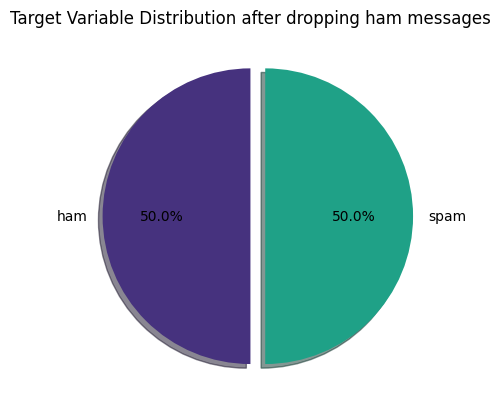

label
ham     747
spam    747
Name: count, dtype: int64


In [12]:
num_spam = target_cat['spam']

# Randomly sampling the majority class to match the count of the minority class
df = pd.concat(
    [
        df[df['label'] == 'ham'].sample(n=num_spam, random_state=42), 
        df[df['label'] == 'spam']
    ]
)

#check the target variable distribution again
target_cat = df.label.value_counts()

#create pie chart using seaborn
color1 = sns.color_palette("viridis")[0]
color2 = sns.color_palette("viridis")[3]

plt.pie(target_cat, labels=target_cat.index, colors=[color1, color2], autopct='%1.1f%%', shadow=True, startangle=90, explode=(0, 0.1))
plt.title('Target Variable Distribution after dropping ham messages')
plt.show()

print(target_cat)


Now we can see that the percentage of ham and spams are Identical. We can proceed with the next step.

### Most Common Words in Spam and Ham Messages (Unigrams)

#### What is Unigrams
Unigrams are the individual words in a sentence. For example, the sentence "I love Python" has three unigrams: "I", "love", and "Python". 


By looking at the most common unigrams in spam and ham messages, we can get a better idea of which words are more prevalent in spam messages vs. ham messages. This might help us later when we try to determine whether a message is spam or ham based on its unigrams.

In [13]:
# Download stopwords (this won't work here due to no internet access, but is generally required when doing this for the first time)

# We'll use a predefined list of stopwords as we can't download them directly here
# stop_words = set([
#     "ourselves", "hers", "between", "yourself", "but",
#     "again", "there", "about", "once", "during", "out",
#     "very", "having", "with", "they", "own", "an", "be",
#     "some", "for", "do", "its", "yours", "such", "into",
#     "of", "most", "itself", "other", "off", "is", "s", "am",
#     "or", "who", "as", "from", "him", "each", "the", "themselves",
#     "until", "below", "are", "we", "these", "your", "his", "through",
#     "don", "nor", "me", "were", "her", "more", "himself", "this",
#     "down", "should", "our", "their", "while", "above", "both", "up",
#     "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before",
#     "them", "same", "and", "been", "have", "in", "will", "on", "does",
#     "yourselves", "then", "that", "because", "what", "over", "why", "so",
#     "can", "did", "not", "now", "under", "he", "you", "herself", "has",
#     "just", "where", "too", "only", "myself", "which", "those", "i",
#     "after", "few", "whom", "t", "being", "if", "theirs", "my", "against",
#     "a", "by", "doing", "it", "how", "further", "was", "here", "than"
# ])

#get the stopwords from nltk
stop_words = set(stopwords.words('english'))


def get_most_common_words(texts, n=10):
    """
    Given a list of texts, return the n most common words.
    """
    # Tokenize the texts and filter out stopwords and non-alphabetic words
    words = []
    for text in texts:
        tokens = word_tokenize(text)
        words.extend([word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words])
    # Count the frequency of each word
    word_freq = Counter(words)
    
    return word_freq.most_common(n)

# Get the 10 most common words for spam and ham messages
common_words_ham = get_most_common_words(df[df['label'] == 'ham']['message'], 10)
common_words_spam = get_most_common_words(df[df['label'] == 'spam']['message'], 10)


#create table to for common_words_ham, common_words_spam
common_words_ham_df = pd.DataFrame(common_words_ham, columns=['word', 'count'])
common_words_spam_df = pd.DataFrame(common_words_spam, columns=['word', 'count'])

# print("Most Frequent Ham words")
# print(common_words_ham_df.to_markdown())

# print("\n\n")


# print("Most Frequent Spam words")
# print(common_words_spam_df.to_markdown())



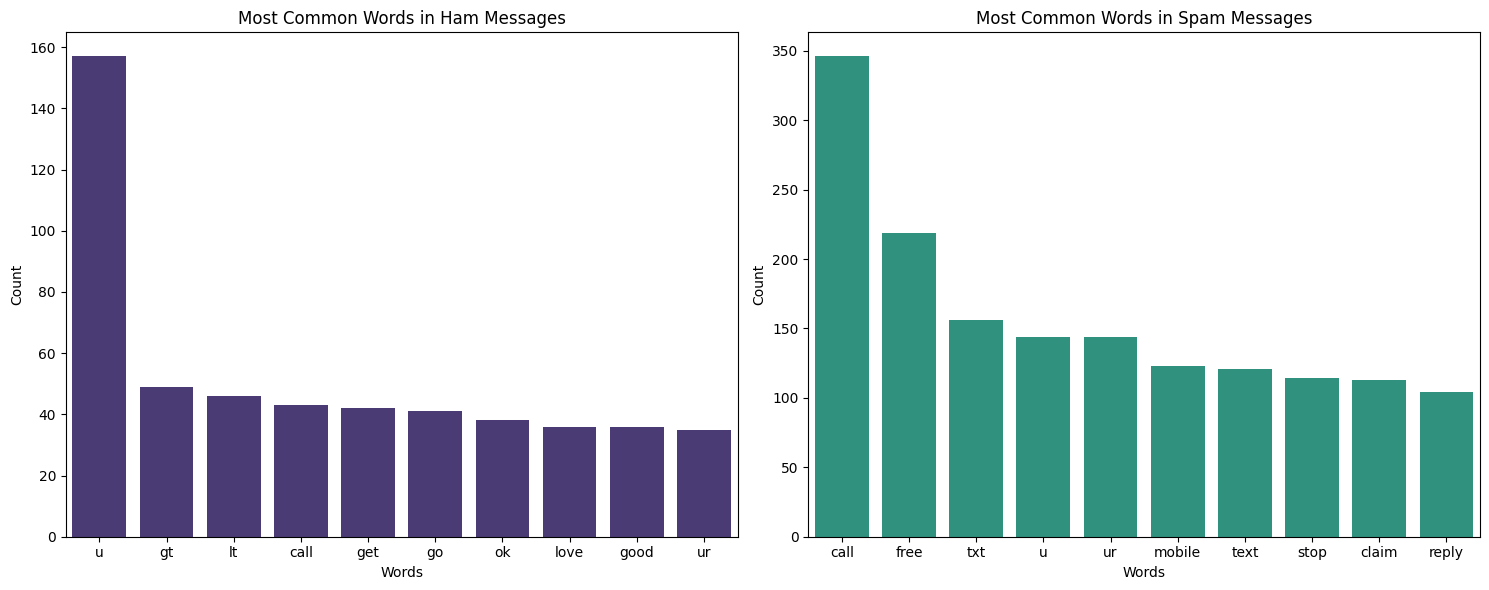

In [14]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 2x1 grid, adjust the size as needed

# Plot for Ham messages
sns.barplot(x=[word[0] for word in common_words_ham], 
            y=[word[1] for word in common_words_ham], 
            color=sns.color_palette("viridis")[0], label='Ham', ax=axes[0])
axes[0].set_title('Most Common Words in Ham Messages')
axes[0].set_xlabel('Words')  # Set x-label
axes[0].set_ylabel('Count')  # Set y-label

# Plot for Spam messages
sns.barplot(x=[word[0] for word in common_words_spam], 
            y=[word[1] for word in common_words_spam], 
            color=sns.color_palette("viridis")[3], label='Spam', ax=axes[1])
axes[1].set_title('Most Common Words in Spam Messages')
axes[1].set_xlabel('Words')  # Set x-label
axes[1].set_ylabel('Count')  # Set y-label

# Adjust layout
plt.tight_layout()
plt.show()

From the above analysis, we can observe that:
- Words like "free", "txt", "text",　"call", "mobile", "claim", and "reply" are more common in spam messages, which makes sense as these words are often associated with promotional or deceptive content.

- Words like "u", "go", "get", "like", "come", and "good" are more common in ham messages, reflecting everyday conversation.

- Also, we can see that count of the words in spam messages. This is proabably spammers are trying to get the attention of the user by repeating the same word multiple times.

Another good method to get overview of the data is to create word cloud. Word cloud is a data visualization technique used for representing text data in which the **size of each word indicates its frequency** or importance.

So, let's create word cloud for spam and ham messages.

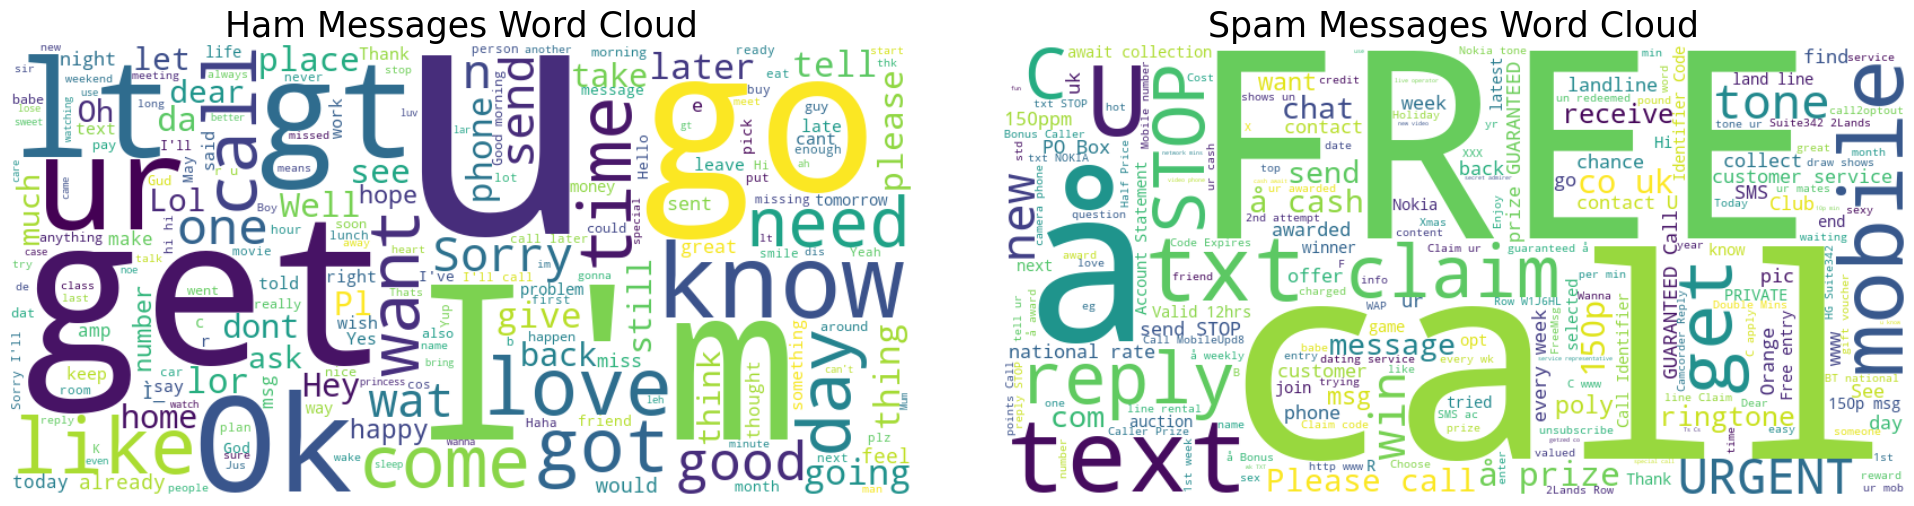

In [15]:
def generate_wordcloud(texts_ham, texts_spam):
    
    all_text_ham = ' '.join(texts_ham)
    all_text_spam = ' '.join(texts_spam)
    
    wordcloud_ham = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(all_text_ham)
    wordcloud_spam = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(all_text_spam)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1.imshow(wordcloud_ham, interpolation='bilinear')
    ax1.axis('off')
    ax1.set_title("Ham Messages Word Cloud", fontsize=25)
    
    ax2.imshow(wordcloud_spam, interpolation='bilinear')
    ax2.axis('off')
    ax2.set_title("Spam Messages Word Cloud", fontsize=25)
    
    plt.tight_layout()
    plt.show()

# Generate word clouds for ham and spam messages side by side
generate_wordcloud(df[df['label'] == 'ham']['message'].tolist(), df[df['label'] == 'spam']['message'].tolist())


Here are the word cloud visualizations for both ham and spam messages:

Ham Messages Word Cloud: Words that stand out in non-spam messages include "I'm", "u", "know", "get", "Ok", "time", and "go". These words are indicative of casual or informal conversations.

Spam Messages Word Cloud: In the spam messages, words like "free", "call", "text", "mobile", "reply", "urgent", and "claim" are prominently visible. These words are often associated with promotional or deceptive content.

### Most Common Bigrams in Spam and Ham Messages

Previously we looked at the most common unigrams in spam and ham messages. Now we are going to look at the most common bigrams.


#### What is Bigrams?
Bigrams, in the context of text analysis, are pairs of consecutive words from a given text or sentence.

Example:
For the sentence "I love ice cream", the bigrams would be:

- I love
- love ice
- ice cream

Let's take a look at the most common bigrams in spam and ham messages. 

In [16]:
def preprocess_message(message):
    # Remove punctuation
    no_punct = ''.join([char for char in message if char not in string.punctuation])
    # Tokenize and remove stop words
    tokens = [word for word in no_punct.split() if word not in stop_words]

    #to lower case 
    tokens = [word.lower() for word in tokens]

    return list(bigrams(tokens))


df["bigrams"] = df["message"].apply(preprocess_message)

# Separate bi-grams by label
spam_bigrams = [bigram for sublist in df[df['label'] == 'spam']['bigrams'] for bigram in sublist]
ham_bigrams = [bigram for sublist in df[df['label'] == 'ham']['bigrams'] for bigram in sublist]

# Count the frequency of each bi-gram in each category
spam_bigrams_count = Counter(spam_bigrams)
ham_bigrams_count = Counter(ham_bigrams)

# Get the most common bi-grams for each category
top_spam_bigrams = spam_bigrams_count.most_common(10)
top_ham_bigrams = ham_bigrams_count.most_common(10)

# top_spam_bigrams, top_ham_bigrams


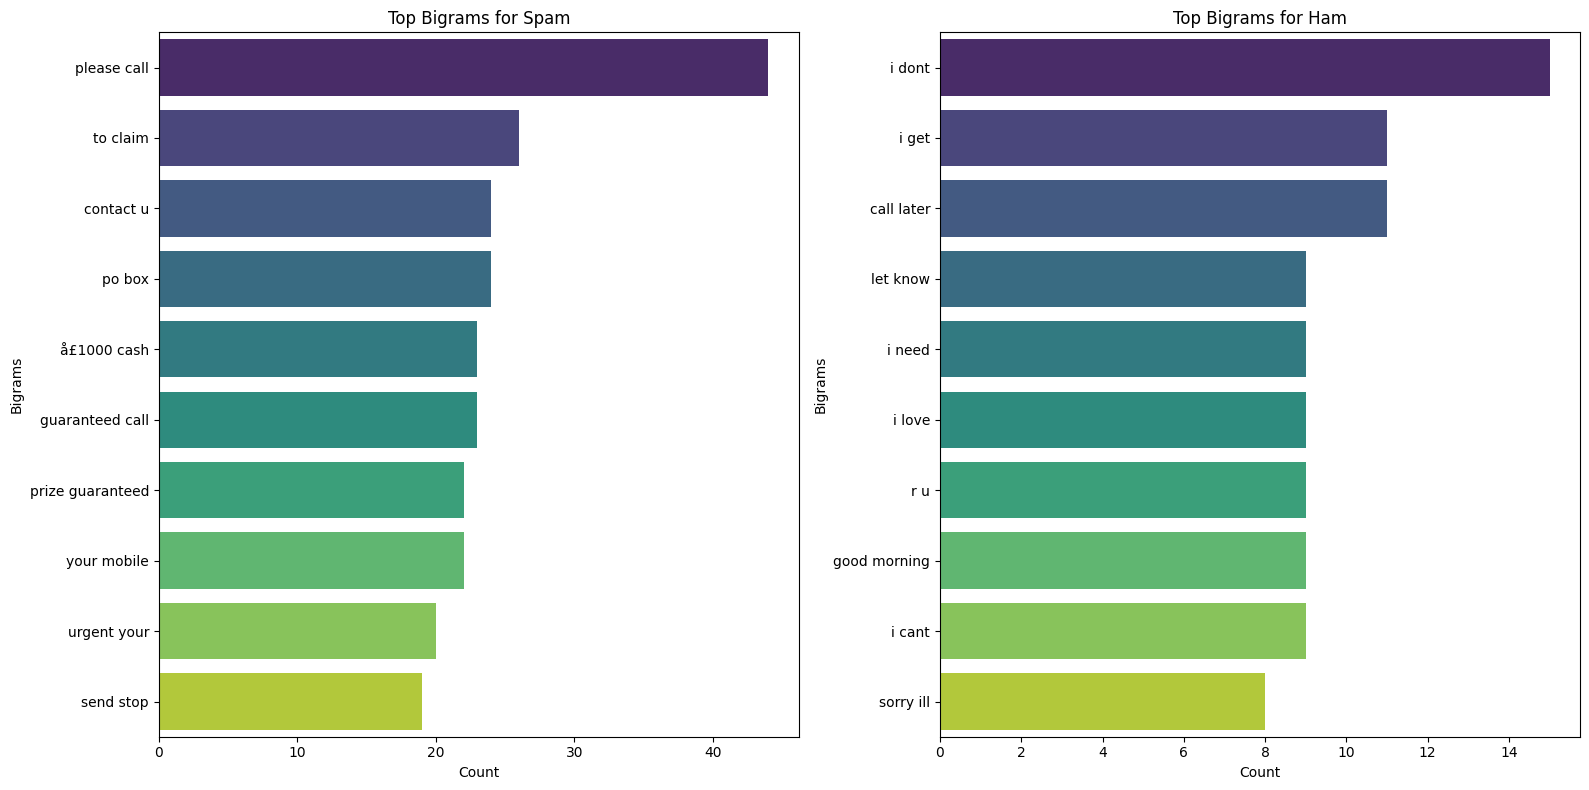

In [17]:
def extract_bigrams_and_counts(bigram_data):
    """Extract bigram labels and values from the given bigram data."""
    labels, values = zip(*[(f"{a[0]} {a[1]}", b) for a, b in bigram_data])
    return labels, values

def create_bigram_dataframe(labels, values):
    """Create a dataframe from bigram labels and values."""
    return pd.DataFrame({
        'Bigrams': labels,
        'Count': values
    })

def plot_bigrams(df, ax, title, palette="viridis"):
    """Plot bigrams using seaborn."""
    sns.barplot(data=df, y='Bigrams', x='Count', ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlabel('Count')
    ax.set_ylabel('Bigrams')

# Extract data
spam_labels, spam_values = extract_bigrams_and_counts(top_spam_bigrams)
ham_labels, ham_values = extract_bigrams_and_counts(top_ham_bigrams)

# Create dataframes
spam_df = create_bigram_dataframe(spam_labels, spam_values)
ham_df = create_bigram_dataframe(ham_labels, ham_values)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
plot_bigrams(spam_df, axes[0], 'Top Bigrams for Spam')
plot_bigrams(ham_df, axes[1], 'Top Bigrams for Ham')

plt.tight_layout()
plt.show()


From this analysis, it's evident that spam messages frequently include prompts for the recipient to take action, such as "please call", "contact u", and "call now". On the other hand, non-spam messages seem to revolve more around everyday conversations, with phrases like "call later", "let know", and "good morning".

### Feature Engineering

#### Message Length
Next, let's visualize the distribution of message lengths for both spam and ham messages. 

This will give us an idea of whether there's any noticeable difference in the length of spam versus non-spam messages.


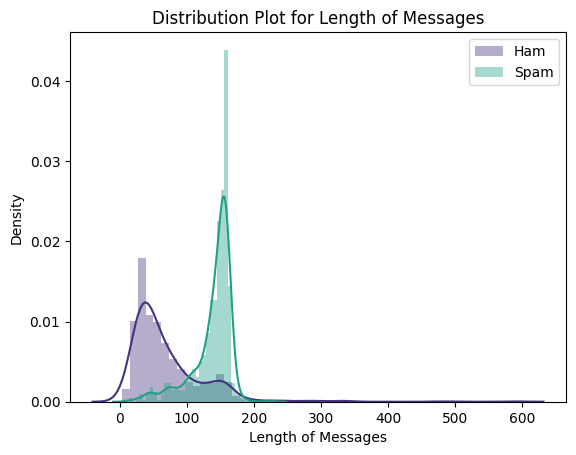

In [18]:
df["msg_len"] = df["message"].apply(len)


sns.distplot(df[df.label == 'ham'].msg_len, label='Ham', color=sns.color_palette("viridis")[0])
sns.distplot(df[df.label == 'spam'].msg_len, label='Spam', color=sns.color_palette("viridis")[3])
plt.title('Distribution Plot for Length of Messages')
plt.xlabel('Length of Messages')
# plt.xticks(range(0, 600, 50))
plt.legend()
plt.show()

Here's a visualization of the distribution of message lengths for both spam and ham messages:

- **Ham (non-spam) Messages:** The majority of ham messages are shorter in length, mostly below 100 characters. There's a peak near the beginning, indicating a significant number of very short ham messages.

- **Spam Messages:** Spam messages tend to be longer on average compared to ham messages. There's a noticeable peak around 150 characters.

The difference in message lengths can be a useful feature when distinguishing between spam and ham messages.

In [19]:
#claculate average message length for spam and ham messages

print('Average message length for ham messages: ', df[df['label'] == 'ham']['message'].str.len().mean())
print('Average message length for spam messages: ', df[df['label'] == 'spam']['message'].str.len().mean())


Average message length for ham messages:  69.11780455153949
Average message length for spam messages:  138.8661311914324


### Punctuations Marks

Let's see if there's any difference in the usage of punctuation marks between spam and ham messages.

In [20]:
# Calculate the  number of punctuations in each message
df['num_punctuations'] = df['message'].apply(lambda x: sum([1 for char in x if char in string.punctuation]))

# Calculate average punctuation  spam and ham messages
avg_punct_ham = df[df['label'] == 'ham']['num_punctuations'].mean()
avg_punct_spam = df[df['label'] == 'spam']['num_punctuations'].mean()

print("Average number of punctuations in ham messages: ", avg_punct_ham)
print("Average number of punctuations in spam messages: ", avg_punct_spam)

Average number of punctuations in ham messages:  3.7295850066934406
Average number of punctuations in spam messages:  5.714859437751004


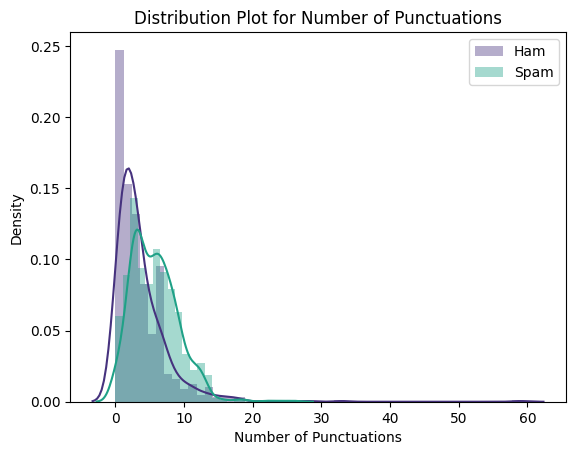

In [21]:
#plot the distribution of number of punctuations by label
sns.distplot(df[df.label == 'ham'].num_punctuations, label='Ham', color=sns.color_palette("viridis")[0])
sns.distplot(df[df.label == 'spam'].num_punctuations, label='Spam', color=sns.color_palette("viridis")[3])
plt.title('Distribution Plot for Number of Punctuations')
plt.xlabel('Number of Punctuations')
plt.legend()
plt.show()


We can see that there's a slight difference in the usage of punctuation marks between spam and ham messages. Spam messages tend to use more question marks and exclamation marks compared to ham messages. This is probably because spam messages often include prompts for the recipient to take action, such as "call now!!!" or "click here!!!!".

### Exclamation Marks

Let's see if there's any difference in the usage of exclamation marks between spam and ham messages.

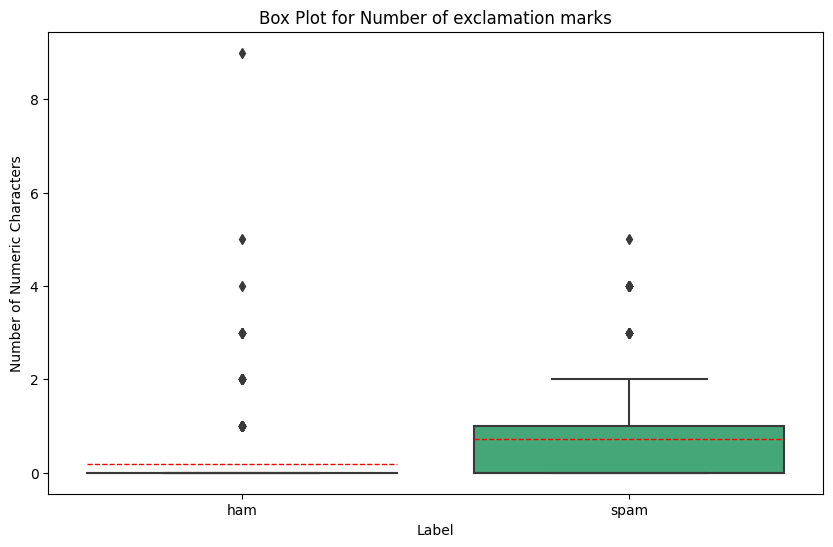

Average number of exclamation marks  in ham messages:  0.17804551539491298
Average number of exclamation marks  in spam messages:  0.7255689424364123


In [22]:
# Calculate the  number of exclamation marks in each message
df['num_exclamation_marks'] = df['message'].apply(lambda x: sum([1 for char in x if char == '!']))

# Calculate average exclamation  spam and ham messages
avg_exclm_ham = df[df['label'] == 'ham']['num_exclamation_marks'].mean()
avg_exclm_spam = df[df['label'] == 'spam']['num_exclamation_marks'].mean()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['label'], y=df['num_exclamation_marks'], palette="viridis", showmeans=True,  meanline=True)
plt.title('Box Plot for Number of exclamation marks')
plt.xlabel('Label')
plt.ylabel('Number of Numeric Characters')

# Set the color of the mean lines
ax = plt.gca()
for line in ax.lines:
    # Check if the line is a mean line (by checking its linestyle) and change its color
    if line.get_linestyle() == '--':
        line.set_color('red')

plt.show()

print("Average number of exclamation marks  in ham messages: ", avg_exclm_ham)
print("Average number of exclamation marks  in spam messages: ", avg_exclm_spam)

The box plot shows that the spam messages tend to have more exclamation marks than the ham messages. The median number of exclamation marks for spam messages is 2, while the median number of exclamation marks for ham messages is 0. There are also a few outliers in the spam messages.

This suggests that the number of exclamation marks can be a useful feature for spam classification. Spam messages often use exclamation marks to grab the reader's attention and make the message seem more urgent or important. Ham messages, on the other hand, are less likely to use exclamation marks.

### Uppercase Letters 

Let's see if there's any difference in the usage of capitalization between spam and ham messages.

In [23]:

# Calculate the  number of capital letters in each message
df['num_upper_case'] = df['message'].apply(lambda x: sum([1 for char in x if char.isupper()]))

avg_caps_ham = df[df['label'] == 'ham']['num_upper_case'].mean()
avg_caps_spam = df[df['label'] == 'spam']['num_upper_case'].mean()


print("Average number of uppercase letters in ham messages: ", avg_caps_ham)
print("Average number of uppercase letters in spam messages: ", avg_caps_spam)

Average number of uppercase letters in ham messages:  4.0
Average number of uppercase letters in spam messages:  15.441767068273093


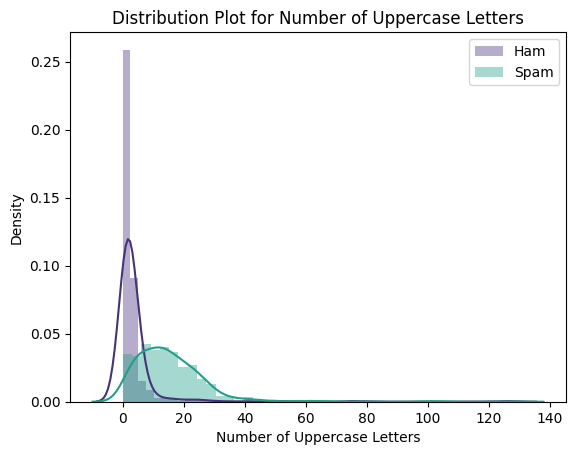

In [24]:
#plot the distribution of number of punctuations by label
sns.distplot(df[df.label == 'ham'].num_upper_case, label='Ham', color=sns.color_palette("viridis")[0])
sns.distplot(df[df.label == 'spam'].num_upper_case, label='Spam', color=sns.color_palette("viridis")[3])
plt.title('Distribution Plot for Number of Uppercase Letters')
plt.xlabel('Number of Uppercase Letters')
plt.legend()
plt.show()


It's interesting to see that spam messages tend to use more capital letters compared to ham messages. This is probably because spam messages often include phrases like "CALL NOW!!!" or "CLICK HERE!!!!", where words are frequently capitalized to capture the recipient's attention.

Next, let's proceed with the Numerical Data Analysis. We'll analyze the frequency of numeric characters in messages to see if there's a significant difference between spam and ham messages.

### Numeric characters

What do you think? Do spam messages tend to have more numeric characters compared to ham messages?
Since you all are familiar with emails, you might have noticed that spam messages often include phone numbers, credit card numbers, or other numeric characters. So, it's reasonable to assume that spam messages tend to have more numeric characters compared to ham messages.

So, Let's check if our hypothesis is correct or not.

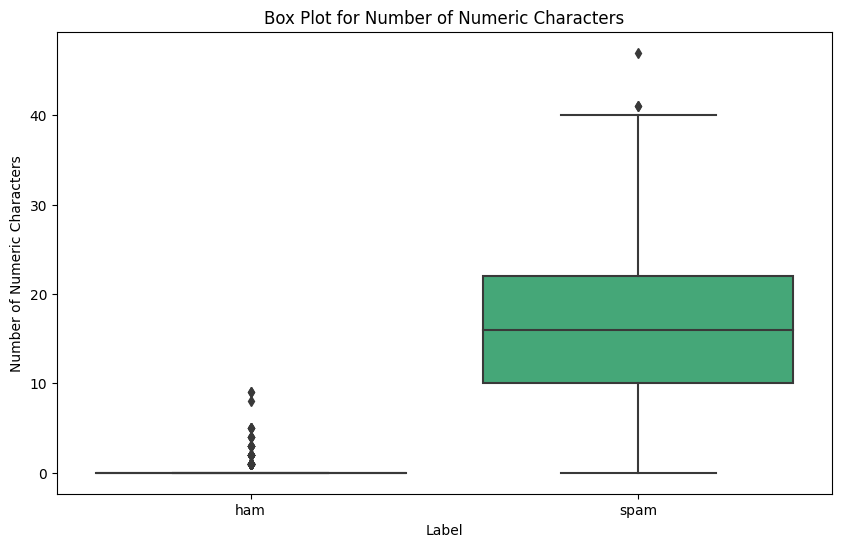

Average number of numeric characters in ham messages:  0.26639892904953144
Average number of numeric characters in spam messages:  15.759036144578314


In [25]:
# Count the number of numeric characters in each message
df['num_numeric'] = df['message'].apply(lambda x: sum([1 for char in x if char.isdigit()]))

# Calculate average numeric characters for spam and ham messages
avg_numeric_ham = df[df['label'] == 'ham']['num_numeric'].mean()
avg_numeric_spam = df[df['label'] == 'spam']['num_numeric'].mean()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['label'], y=df['num_numeric'], palette="viridis")
plt.title('Box Plot for Number of Numeric Characters')
plt.xlabel('Label')
plt.ylabel('Number of Numeric Characters')
plt.show()

print("Average number of numeric characters in ham messages: ", avg_numeric_ham)
print("Average number of numeric characters in spam messages: ", avg_numeric_spam)


The above box plot shows the following:

- The median number of numerical characters is higher for spam emails than ham emails.
- The interquartile range (IQR) is wider for spam emails. This means that there is more variation in the number of numerical characters for spam emails.
- There are a few outliers for spam emails with a very high number of numerical characters.

As we can see, spam messages tend to have more numeric characters compared to ham messages. This is probably because spam messages often include phone numbers, monetary figures, or other promotional numbers. or other numeric characters.

Considering these insights, the presence of numeric characters can be a useful feature for distinguishing between spam and non-spam messages.

### Number of Sentences

Now lets check the number of sentences in each message. We can use the number of sentences as a feature to distinguish between spam and ham messages if there's a significant difference between the two.

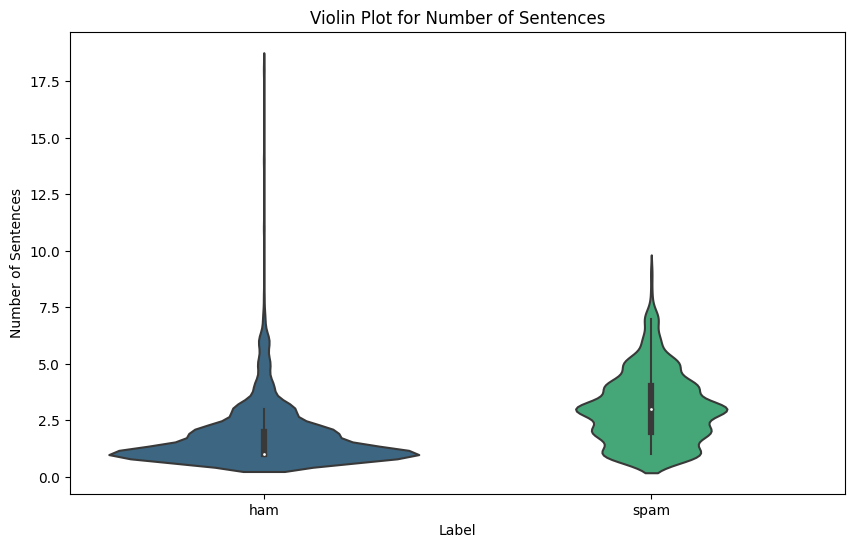

Average number of sentences in ham messages:  1.8286479250334673
Average number of sentences in spam messages:  3.0214190093708164


In [26]:
# Tokenize messages and compute the number of sentences
df['num_sentences'] = df['message'].apply(lambda x: len(sent_tokenize(x)))

# Calculate average number of sentences for spam and ham messages
avg_sentences_ham = df[df['label'] == 'ham']['num_sentences'].mean()
avg_sentences_spam = df[df['label'] == 'spam']['num_sentences'].mean()

plt.figure(figsize=(10, 6))
sns.violinplot(x=df['label'], y=df['num_sentences'], palette="viridis")
plt.title('Violin Plot for Number of Sentences')
plt.xlabel('Label')
plt.ylabel('Number of Sentences')
plt.show()

print("Average number of sentences in ham messages: ", avg_sentences_ham)
print("Average number of sentences in spam messages: ", avg_sentences_spam)


Here are the key points of the violin plot:

- The median number of sentences in spam messages is around 3, while the median number of sentences in ham messages lower.
- There is a clear overlap between the two distributions, but the spam messages tend to have a higher number of sentences.



### Number of Words

Previously we looked in to the length of the messages. Now we are going to look at the number of words in each message. Since 
spam messages tend to be longer on average compared to ham messages, we can expect that spam messages also have a higher number of words on average. 


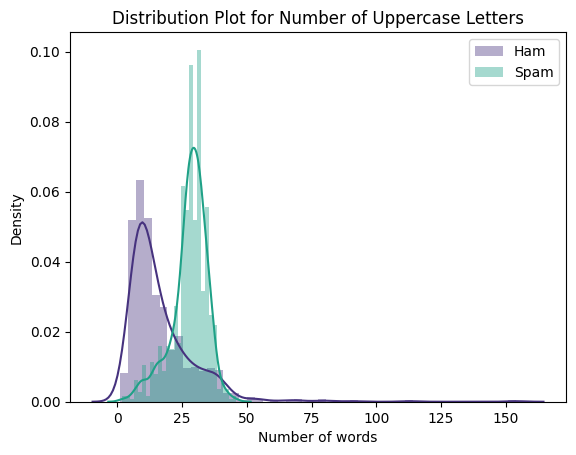

Average number of words in ham messages:  16.82463186077644
Average number of words in spam messages:  27.89156626506024


In [27]:
# Tokenize messages and compute the number of words
df['num_words'] = df['message'].apply(lambda x: len(word_tokenize(x)))

# Calculate average number of words for spam and ham messages
avg_words_ham = df[df['label'] == 'ham']['num_words'].mean()
avg_words_spam = df[df['label'] == 'spam']['num_words'].mean()


#plot the distribution of number of punctuations by label
sns.distplot(df[df.label == 'ham'].num_words, label='Ham', color=sns.color_palette("viridis")[0])
sns.distplot(df[df.label == 'spam'].num_words, label='Spam', color=sns.color_palette("viridis")[3])
plt.title('Distribution Plot for Number of Uppercase Letters')
plt.xlabel('Number of words')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
# sns.boxplot(x=df['label'], y=df['num_words'], palette="viridis")
# plt.title('Box Plot for Number of Words')
# plt.xlabel('Label')
# plt.ylabel('Number of Words')
# plt.show()

print("Average number of words in ham messages: ", avg_words_ham)
print("Average number of words in spam messages: ", avg_words_spam)

This distribution plot suggests that spam texts are more likely to use more words in a more exaggerated or conspicuous way than ham texts. This could be because spammers want to make their messages stand out from the rest of the inbox.




Building an effective machine learning model for spam detection requires carefully selected features that can capture the underlying patterns distinguishing spam from ham messages. Based on our EDA and domain knowledge, here are some potential features:}


- Text Length: As observed, spam messages tend to be longer on average.
- Number of Numeric Characters: Spam messages often contain numbers (like amounts, phone numbers, or PINs).
- Number of Uppercase Letters: Spam messages might use uppercase letters more frequently to grab attention.
- Number of Punctuations: Our analysis indicated a difference in punctuation usage between spam and ham messages.
- Number of Words: Spam messages tend to have a higher number of words.
- Number of Sentences: Spam messages tend to have a higher number of sentences.
- Number of Exclamation Marks: Spam messages tend to use more exclamation marks to grab attention.


#### correlation analysis is important but it may be difficult to interpret the results. So, Im thinking to skip this section and directly going to the next section.Which is using all features and train the model.

In [28]:
df

,label,message,bigrams,msg_len,num_punctuations,num_exclamation_marks,num_upper_case,num_numeric,num_sentences,num_words
3714,ham,"I am late,so call you tomorrow morning.take ca...","[(i, lateso), (lateso, call), (call, tomorrow)...",92,13,0,1,0,1,21
1311,ham,U r too much close to my heart. If u go away i...,"[(u, r), (r, much), (much, close), (close, hea...",83,3,0,3,0,3,23
548,ham,Wait &lt;#&gt; min..,"[(wait, ltgt), (ltgt, min)]",22,7,0,1,0,1,10
1324,ham,Can you call me plz. Your number shows out of ...,"[(can, call), (call, plz), (plz, your), (your,...",139,5,0,3,1,3,35
3184,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,"[(maybe, if), (if, you), (you, woke), (woke, u...",65,2,0,50,1,1,15
...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,"[(want, explicit), (explicit, sex), (sex, 30),...",90,3,1,17,21,3,18
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,"[(asked, 3mobile), (3mobile, if), (if, 0870), ...",160,5,0,104,14,6,38
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,"[(had, contract), (contract, mobile), (mobile,...",160,8,1,20,2,5,35
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,"[(reminder, from), (from, o2), (o2, to), (to, ...",147,3,0,14,5,1,30


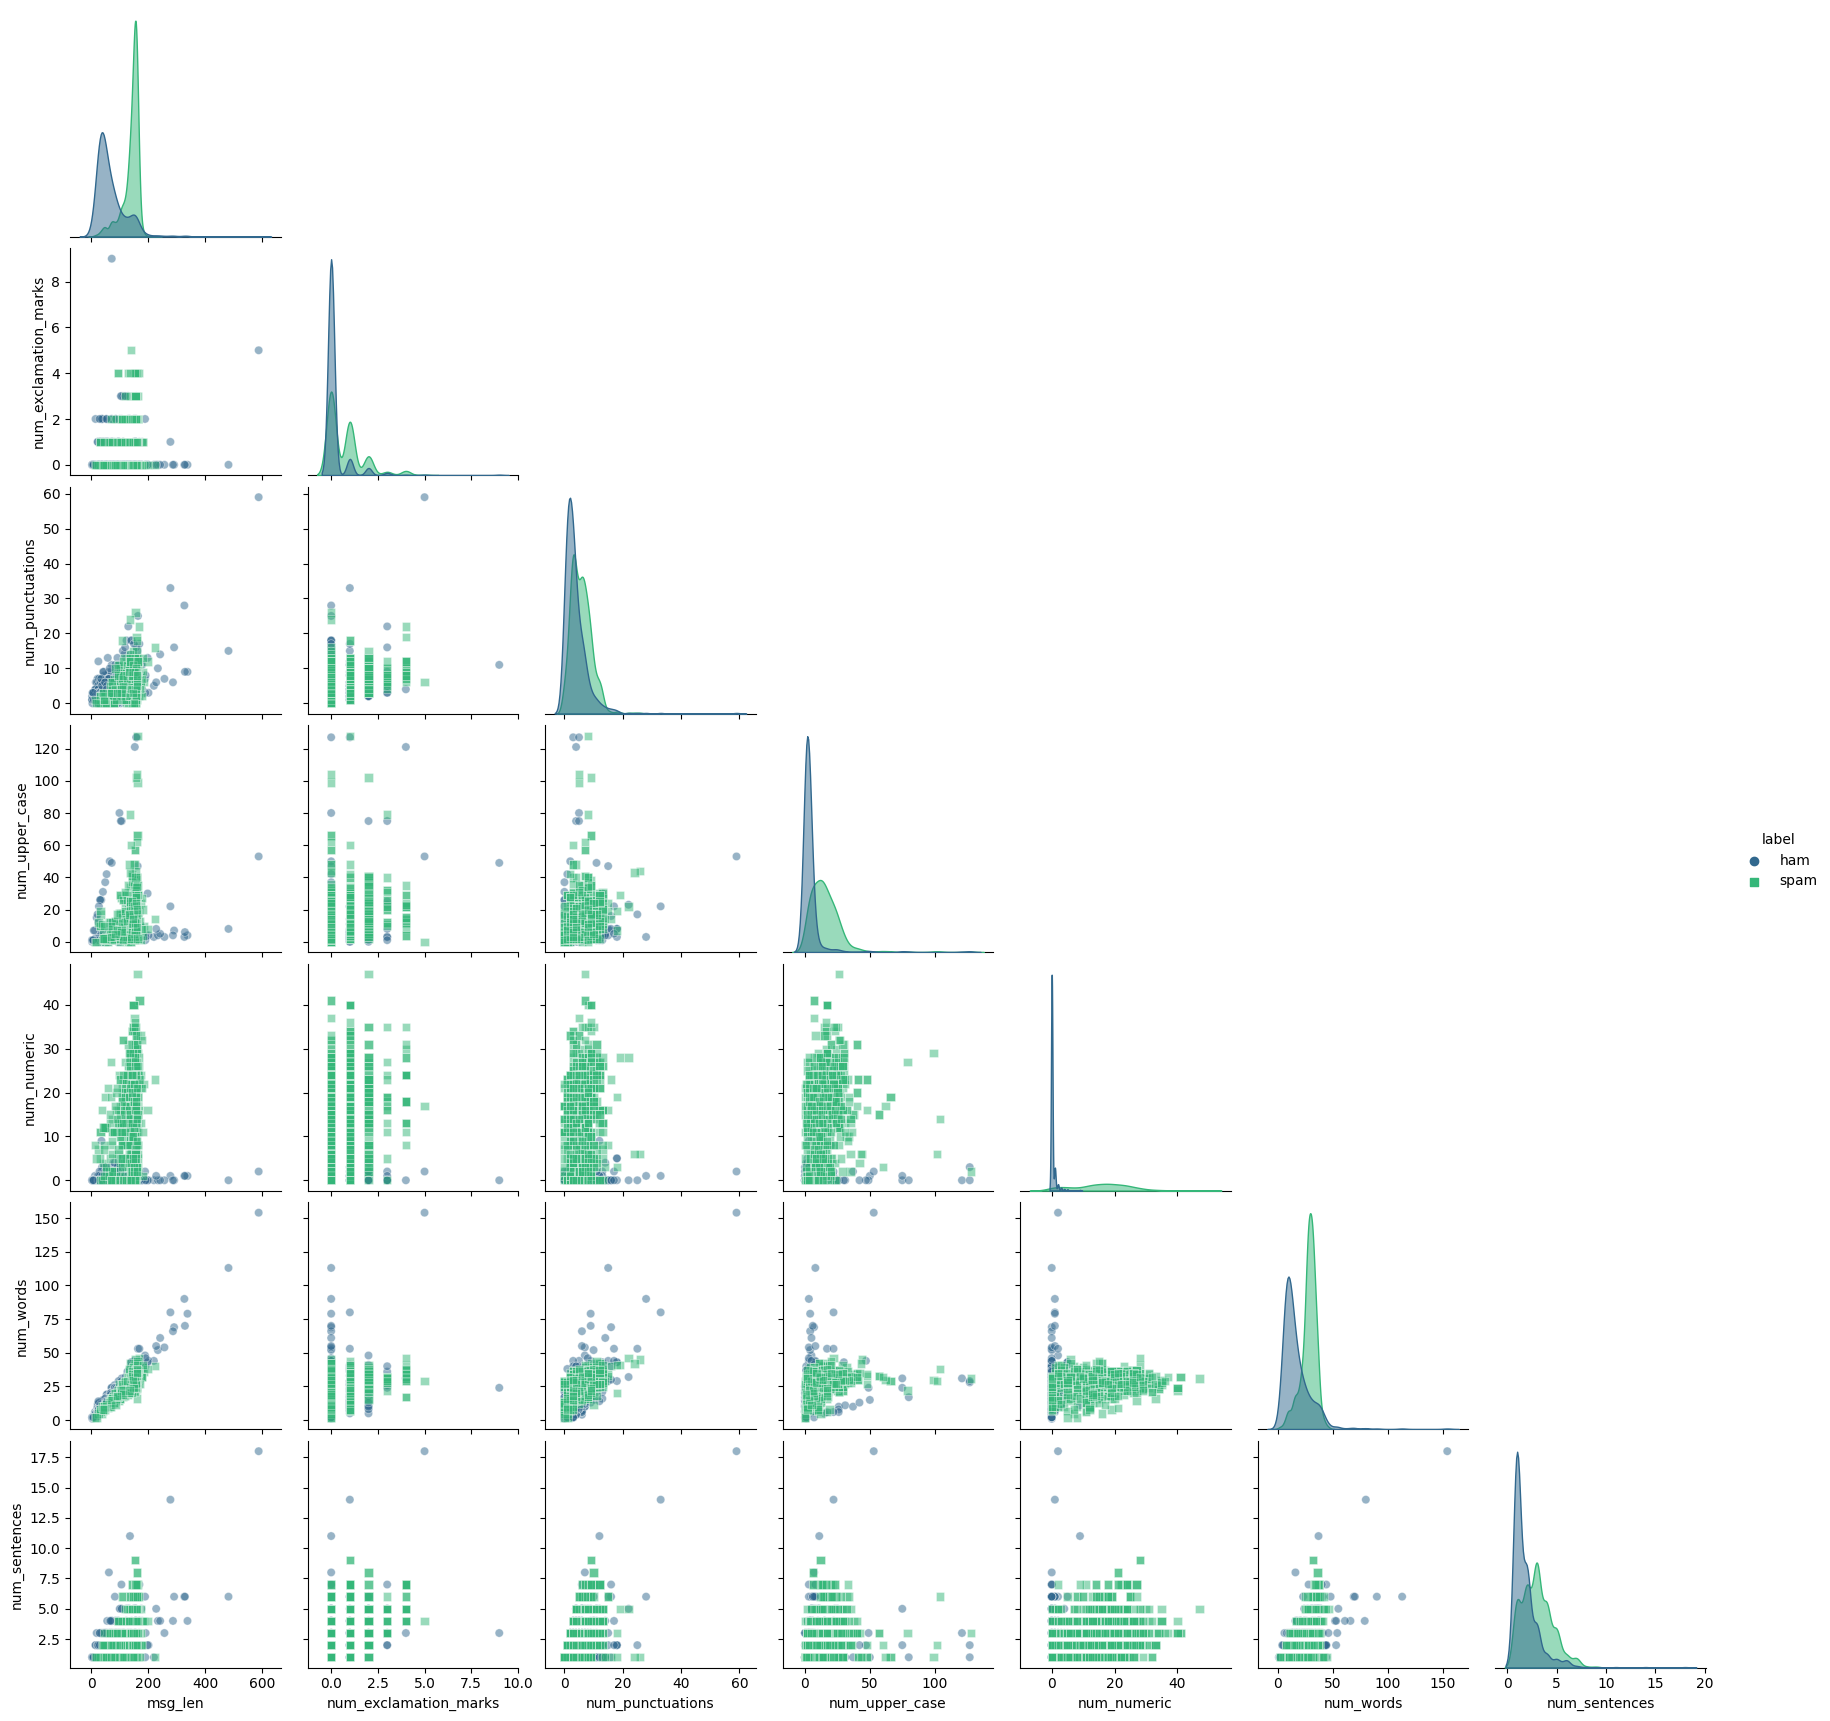

In [29]:
def corr_callback(x, y, **kwargs):
    """Annotate the scatterplot with the Pearson correlation coefficient."""
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes, color='red')


# Selecting the numeric columns for the pairplot
numeric_cols = ['msg_len', 'num_exclamation_marks', 'num_punctuations', 'num_upper_case', 'num_numeric', 'num_words', 'num_sentences']

# Generate the pairplot
# sns.pairplot(df, vars=numeric_cols, hue='label', palette="viridis")
# plt.show()

# Generate the pairplot with correlation coefficients
sns.pairplot(df, vars=numeric_cols, hue='label', palette="viridis",
             plot_kws={'alpha': 0.5, 'marker': '.'},
             corner=True, diag_kind='kde', markers=["o", "s"],
             diag_kws={'alpha': 0.5}).map_upper(corr_callback)
plt.show()

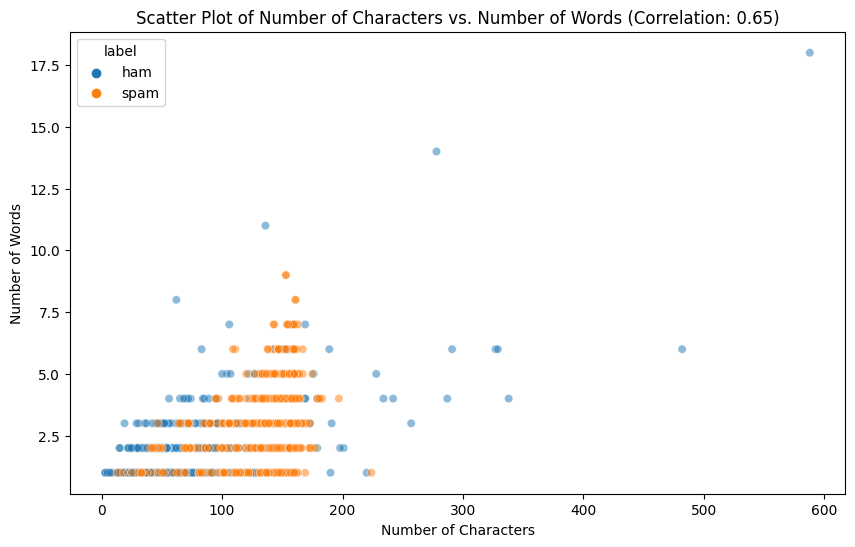

In [30]:
# Calculate the number of characters for each message
df['num_char'] = df['message'].apply(len)

# Compute the Pearson correlation
correlation = df['num_words'].corr(df['num_sentences'])

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['num_char'], y=df['num_sentences'], hue=df['label'], alpha=0.5)
plt.title(f'Scatter Plot of Number of Characters vs. Number of Words (Correlation: {correlation:.2f})')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Words')
plt.show()

In [31]:
df["text_len"] = df["message"].apply(len)


In [32]:
df

,label,message,bigrams,msg_len,num_punctuations,num_exclamation_marks,num_upper_case,num_numeric,num_sentences,num_words,num_char,text_len
3714,ham,"I am late,so call you tomorrow morning.take ca...","[(i, lateso), (lateso, call), (call, tomorrow)...",92,13,0,1,0,1,21,92,92
1311,ham,U r too much close to my heart. If u go away i...,"[(u, r), (r, much), (much, close), (close, hea...",83,3,0,3,0,3,23,83,83
548,ham,Wait &lt;#&gt; min..,"[(wait, ltgt), (ltgt, min)]",22,7,0,1,0,1,10,22,22
1324,ham,Can you call me plz. Your number shows out of ...,"[(can, call), (call, plz), (plz, your), (your,...",139,5,0,3,1,3,35,139,139
3184,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,"[(maybe, if), (if, you), (you, woke), (woke, u...",65,2,0,50,1,1,15,65,65
...,...,...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,"[(want, explicit), (explicit, sex), (sex, 30),...",90,3,1,17,21,3,18,90,90
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,"[(asked, 3mobile), (3mobile, if), (if, 0870), ...",160,5,0,104,14,6,38,160,160
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,"[(had, contract), (contract, mobile), (mobile,...",160,8,1,20,2,5,35,160,160
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,"[(reminder, from), (from, o2), (o2, to), (to, ...",147,3,0,14,5,1,30,147,147


## Model Training

In many machine learning algorithms, categorical labels (or features) need to be converted to numerical values because the algorithms are designed to work with numbers. This process is known as "encoding."

For binary classification problems like the one you've shown (with only two classes: "spam" and "ham"), the most common encoding method is "binary encoding" or "label encoding." In this method, you assign one class to 0 and the other class to 1. For instance:

spam: 1
ham: 0

However, if you had more than two classes, you might consider using "one-hot encoding." This method creates a binary column for each category and returns a matrix with rows equal to the number of samples and columns equal to the number of categories. But for your current dataset, a binary encoding is appropriate.

In Python, you can use the LabelEncoder class from the sklearn.preprocessing module to easily convert "spam" and "ham" to 1 and 0 respectively. Here's how you can do it:

In [33]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df['label'])
df['encoded_label'] = encoded_labels
df

,label,message,bigrams,msg_len,num_punctuations,num_exclamation_marks,num_upper_case,num_numeric,num_sentences,num_words,num_char,text_len,encoded_label
3714,ham,"I am late,so call you tomorrow morning.take ca...","[(i, lateso), (lateso, call), (call, tomorrow)...",92,13,0,1,0,1,21,92,92,0
1311,ham,U r too much close to my heart. If u go away i...,"[(u, r), (r, much), (much, close), (close, hea...",83,3,0,3,0,3,23,83,83,0
548,ham,Wait &lt;#&gt; min..,"[(wait, ltgt), (ltgt, min)]",22,7,0,1,0,1,10,22,22,0
1324,ham,Can you call me plz. Your number shows out of ...,"[(can, call), (call, plz), (plz, your), (your,...",139,5,0,3,1,3,35,139,139,0
3184,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,"[(maybe, if), (if, you), (you, woke), (woke, u...",65,2,0,50,1,1,15,65,65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,"[(want, explicit), (explicit, sex), (sex, 30),...",90,3,1,17,21,3,18,90,90,1
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,"[(asked, 3mobile), (3mobile, if), (if, 0870), ...",160,5,0,104,14,6,38,160,160,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,"[(had, contract), (contract, mobile), (mobile,...",160,8,1,20,2,5,35,160,160,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,"[(reminder, from), (from, o2), (o2, to), (to, ...",147,3,0,14,5,1,30,147,147,1


In [34]:
# Display classes and their encoded values
for original, encoded in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"'{original}' is encoded as {encoded}")

'ham' is encoded as 0
'spam' is encoded as 1


In [35]:
encoder.classes_

array(['ham', 'spam'], dtype=object)

In [36]:
df.columns

Index(['label', 'message', 'bigrams', 'msg_len', 'num_punctuations',
       'num_exclamation_marks', 'num_upper_case', 'num_numeric',
       'num_sentences', 'num_words', 'num_char', 'text_len', 'encoded_label'],
      dtype='object')

Let's select what features we are going to use for the model. We are going to use all the numerical features.
- Message Length
- Number of Numeric Characters
- Number of Uppercase Letters
- Number of Punctuations
- Number of Words
- Number of Sentences
- Number of Exclamation Marks

 Then for the target variable we are going to use the label column.

 After that we are going to split the data set into training and test set. We are going to use 80% of the data for training and 20% of the data for testing. 

In [37]:
X = df[['msg_len', 'num_exclamation_marks', 'num_punctuations', 'num_upper_case', 'num_numeric', 'num_words', 'num_sentences']]
y = df["encoded_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
#print information of train and test set

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (1045, 7)
X_test shape:  (449, 7)
y_train shape:  (1045,)
y_test shape:  (449,)


We are using many models at once

In [39]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(kernel="linear", random_state=42),
    "KNN" : KNeighborsClassifier(),
    "XGB": XGBClassifier(objective='binary:hinge', random_state=42),
    "Multinomial NB": MultinomialNB(),
    "LGBM" : LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=42)

}


In [40]:
# Creating a function train each model and calculate/return accuracy and precision

def train_clf(model, X_train, y_train, X_test, y_test):

    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and get accuracy and precision
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    cfs = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, auc, cfs


In [41]:
acc_s = []
pre_s = []
rec_s = []
f1_s = []
auc_s = []
cnf_s = []


for name, model in models.items():
    accuracy, precision, recall, f1, auc, confusion = train_clf(model, X_train, y_train, X_test, y_test)

    acc_s.append(accuracy)
    pre_s.append(precision)
    rec_s.append(recall)
    f1_s.append(f1)
    auc_s.append(auc)
    cnf_s.append(confusion)


scores_df = pd.DataFrame({
    "Algorithm": list(models.keys()),
    "Accuracy": acc_s,
    "Precision": pre_s,
    "Recall": rec_s, 
    "F1 Score": f1_s,
    "Roc Auc Score": auc_s,
    "Confusion Matrix": cnf_s
}).sort_values(by="F1 Score", ascending=False)

[LightGBM] [Info] Number of positive: 515, number of negative: 530
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 1045, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492823 -> initscore=-0.028710
[LightGBM] [Info] Start training from score -0.028710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [43]:
scores_df

,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score,Confusion Matrix
0,Random Forest,0.973274,0.986726,0.961207,0.973799,0.973691,"[[214, 3], [9, 223]]"
5,XGB,0.971047,0.969957,0.974138,0.972043,0.970940,"[[210, 7], [6, 226]]"
7,LGBM,0.962138,0.977778,0.948276,0.962801,0.962617,"[[212, 5], [12, 220]]"
1,Decision Tree,0.957684,0.965066,0.952586,0.958785,0.957860,"[[209, 8], [11, 221]]"
4,KNN,0.955457,0.969027,0.943966,0.956332,0.955854,"[[210, 7], [13, 219]]"
2,Logistic Regression,0.953229,0.968889,0.939655,0.954048,0.953699,"[[210, 7], [14, 218]]"
3,SVC,0.951002,0.972973,0.931034,0.951542,0.951692,"[[211, 6], [16, 216]]"
6,Multinomial NB,0.919822,0.962264,0.879310,0.918919,0.921222,"[[209, 8], [28, 204]]"


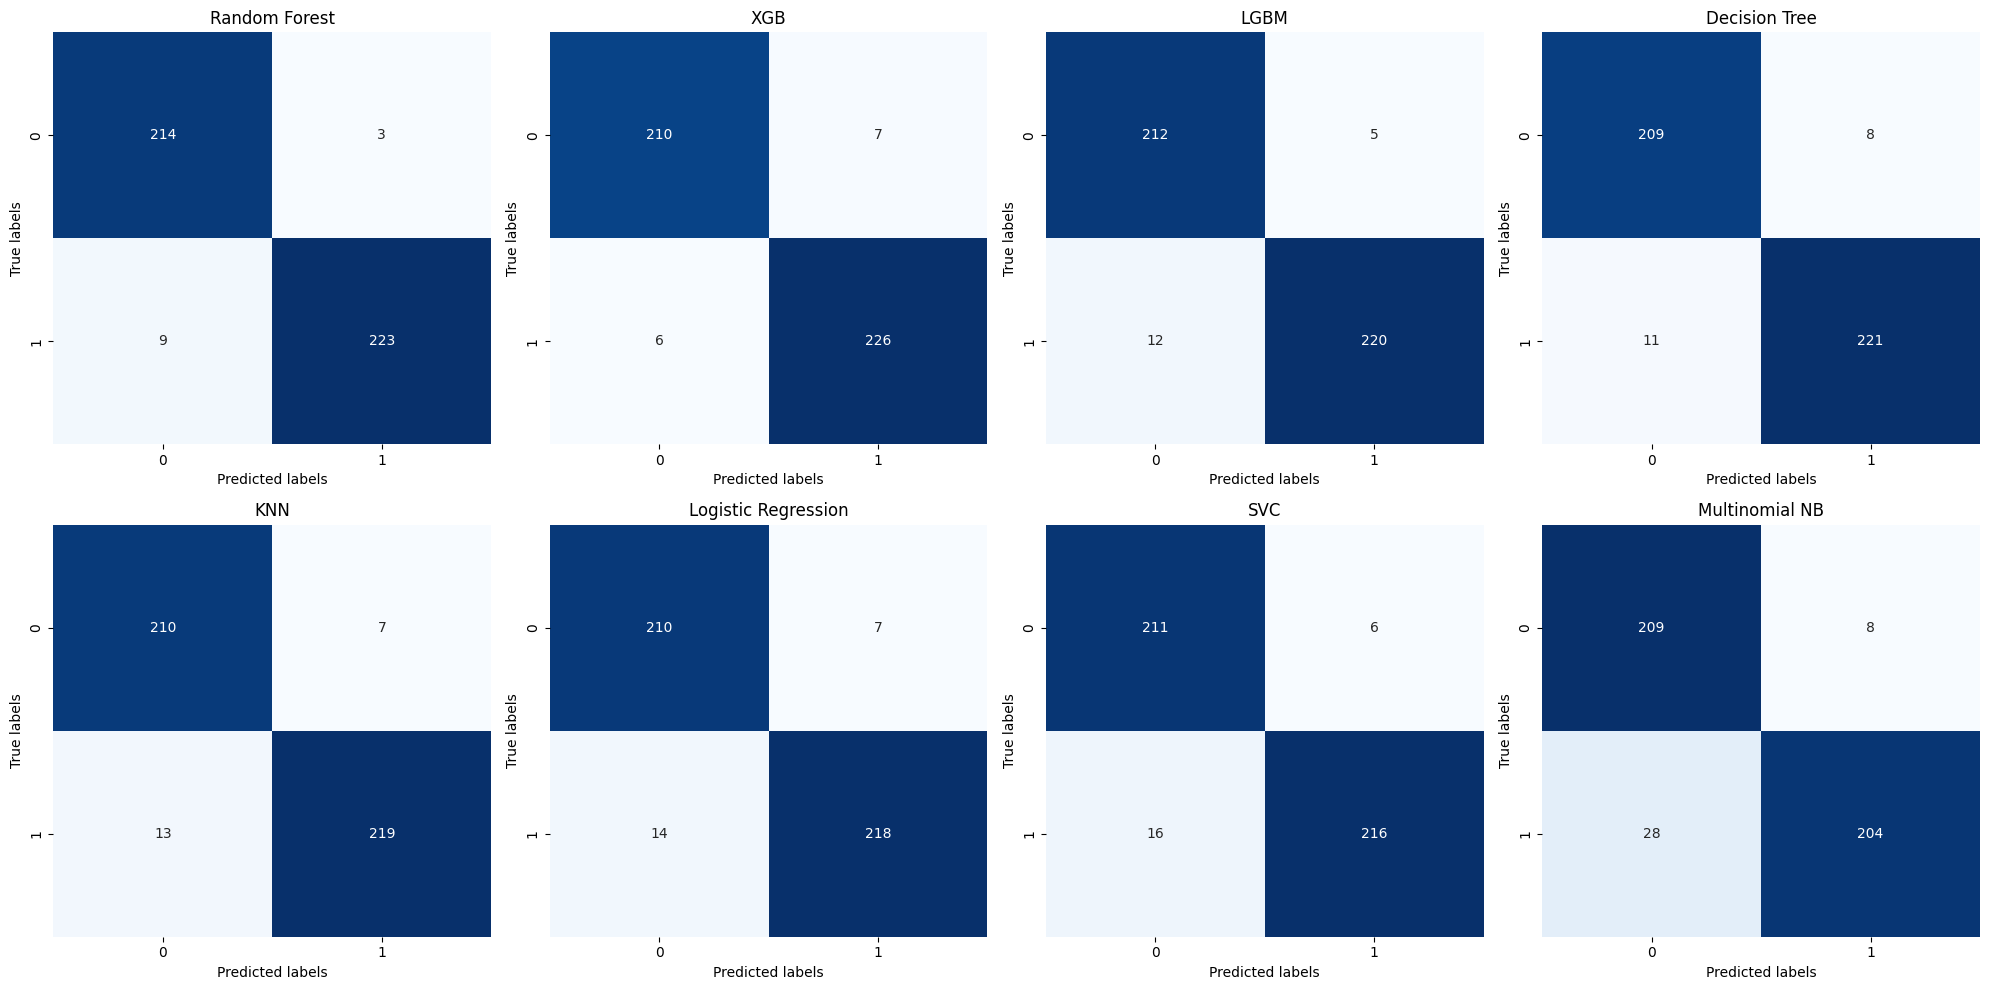

In [44]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for idx, ax in enumerate(axes.flatten()):
    algo = scores_df.iloc[idx]['Algorithm']
    cm = scores_df.iloc[idx]['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(algo)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

plt.tight_layout()
plt.show()

In [42]:
scores_df
# SVC	0.936652	0.957672	0.900498	0.928205	0.933651

,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
5,XGB,0.971047,0.969957,0.974138,0.972043,0.970940
0,Random Forest,0.971047,0.991031,0.952586,0.971429,0.971685
7,LGBM,0.964365,0.977876,0.952586,0.965066,0.964772
1,Decision Tree,0.957684,0.965066,0.952586,0.958785,0.957860
4,KNN,0.955457,0.969027,0.943966,0.956332,0.955854
2,Logistic Regression,0.955457,0.969027,0.943966,0.956332,0.955854
3,SVC,0.951002,0.972973,0.931034,0.951542,0.951692
6,Multinomial NB,0.917595,0.957746,0.879310,0.916854,0.918918


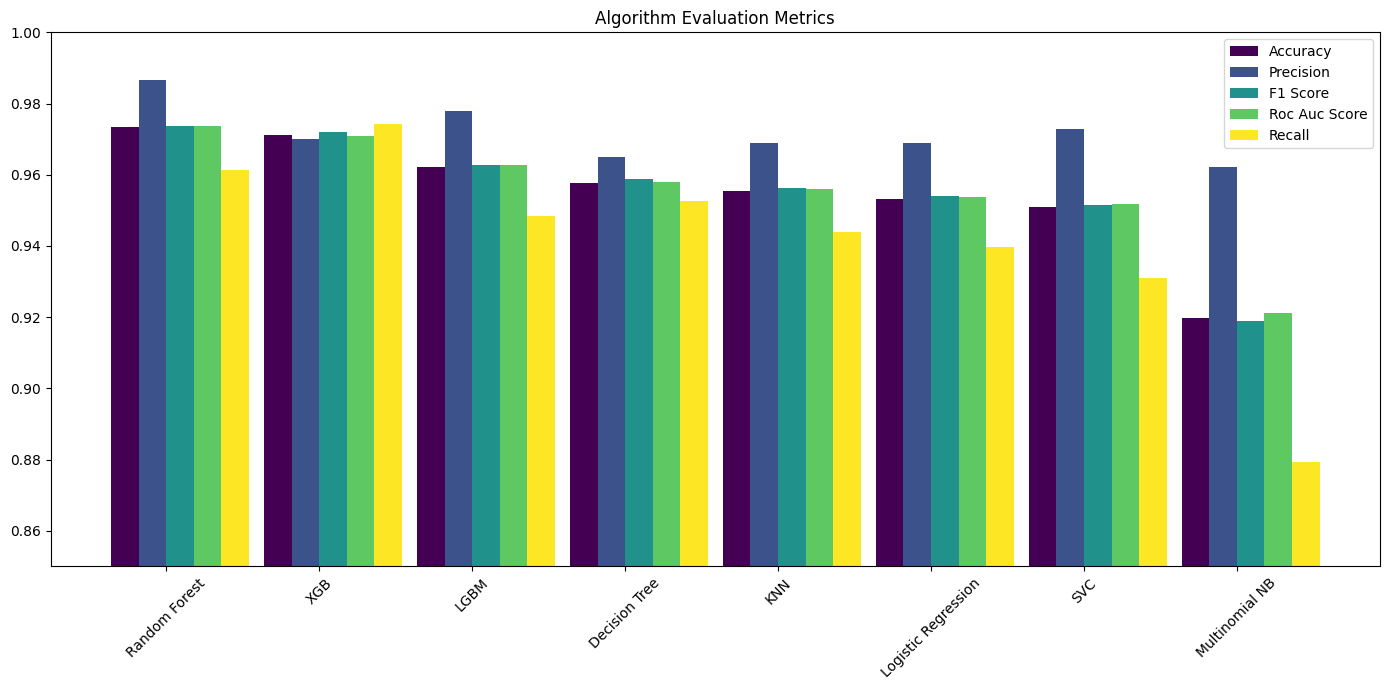

In [45]:
# Number of algorithms

#remove index columnof scores_df
scores_df = scores_df.reset_index(drop=True)

# Getting the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 5))


N = len(scores_df['Algorithm'])

# Indices for bar positions
ind = np.arange(N)

# Width of the bars
width = 0.18

fig, ax = plt.subplots(figsize=(14, 7))

# Bar plots for each metric
p1 = ax.bar(ind, scores_df['Accuracy'], width, label='Accuracy', color=colors[0])
p2 = ax.bar(ind + width, scores_df['Precision'], width, label='Precision', color=colors[1])
p3 = ax.bar(ind + 2 * width, scores_df['F1 Score'], width, label='F1 Score', color=colors[2])
p4 = ax.bar(ind + 3 * width, scores_df['Roc Auc Score'], width, label='Roc Auc Score', color=colors[3])
p5 = ax.bar(ind + 4 * width, scores_df['Recall'], width, label='Recall', color=colors[4])

# Axes and labels
ax.set_title('Algorithm Evaluation Metrics')
ax.set_xticks(ind + 1.5 * width)
ax.set_xticklabels(scores_df['Algorithm'], rotation=45)
ax.set_ylim([0.85, 1.0])
ax.legend()

plt.tight_layout()
plt.show()

In [48]:
scores_df_heat

,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
0,Random Forest,0.973274,0.986726,0.961207,0.973799,0.973691
1,XGB,0.971047,0.969957,0.974138,0.972043,0.970940
2,LGBM,0.962138,0.977778,0.948276,0.962801,0.962617
3,Decision Tree,0.957684,0.965066,0.952586,0.958785,0.957860
4,KNN,0.955457,0.969027,0.943966,0.956332,0.955854
5,Logistic Regression,0.953229,0.968889,0.939655,0.954048,0.953699
6,SVC,0.951002,0.972973,0.931034,0.951542,0.951692
7,Multinomial NB,0.919822,0.962264,0.879310,0.918919,0.921222


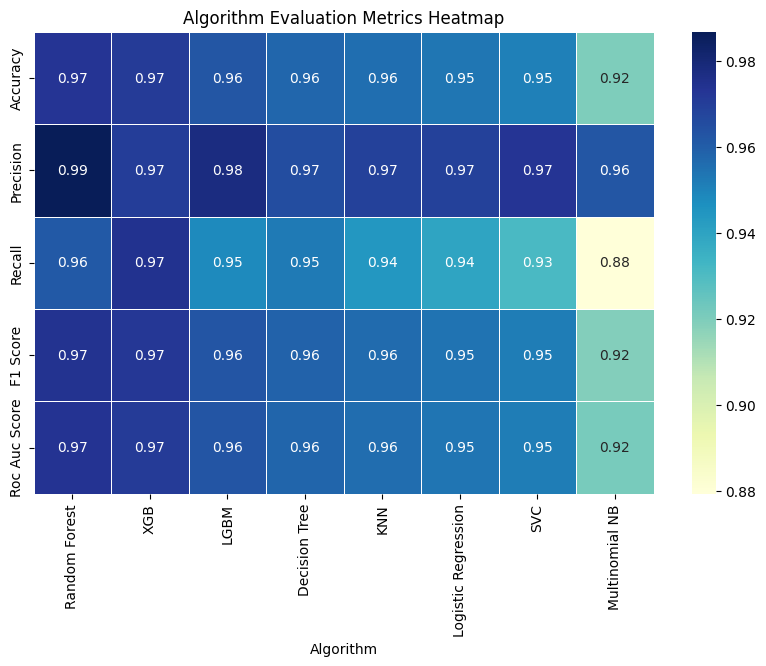

In [49]:
#createnew df for heatmap withput confusion matrix
scores_df_heat = scores_df.drop(['Confusion Matrix'], axis=1)
# Heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(scores_df_heat.set_index('Algorithm').T, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Algorithm Evaluation Metrics Heatmap')
plt.show()

In [52]:
# Function to highlight the maximum in each column
def highlight_column_max(s, color='yellow'):
    is_max = s == s.max()
    return [f'background-color: {color}' if v else '' for v in is_max]

# Applying the highlighting function to the dataframe
df_style = scores_df_heat.set_index('Algorithm').style.apply(highlight_column_max, color='lime', axis=0)
df_style

,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
Algorithm,,,,,
Random Forest,0.973274,0.986726,0.961207,0.973799,0.973691
XGB,0.971047,0.969957,0.974138,0.972043,0.970940
LGBM,0.962138,0.977778,0.948276,0.962801,0.962617
Decision Tree,0.957684,0.965066,0.952586,0.958785,0.957860
KNN,0.955457,0.969027,0.943966,0.956332,0.955854
Logistic Regression,0.953229,0.968889,0.939655,0.954048,0.953699
SVC,0.951002,0.972973,0.931034,0.951542,0.951692
Multinomial NB,0.919822,0.962264,0.879310,0.918919,0.921222


In [113]:


rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
lrc = LogisticRegression(random_state=42)
svc_c = SVC(kernel="linear", random_state=42, probability=True)
knnc = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:hinge',random_state=42)
lgbm = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=8888)


rfc.fit(X_train, y_train)
lrc.fit(X_train, y_train)
svc_c.fit(X_train, y_train)
knnc.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

votingC = VotingClassifier(estimators=[
    ('Random Forest', rfc),
    ('Logistic Regression', lrc),
    ('SVC',svc_c),
    ("XGB",xgb),
    ("KNN",knnc),
    ("LGBM",lgbm)
    ],
    voting='soft'
)

votingC = votingC.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 515, number of negative: 530
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 1045, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492823 -> initscore=-0.028710
[LightGBM] [Info] Start training from score -0.028710
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [114]:
vote_pred = votingC.predict(X_test)

In [115]:
accuracy = accuracy_score(y_test, vote_pred)
precision = precision_score(y_test, vote_pred)
recall = recall_score(y_test, vote_pred)
f1 = f1_score(y_test, vote_pred)
auc = roc_auc_score(y_test, vote_pred)


print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))
print('Roc Auc Score: {:.2f}'.format(auc))

Accuracy: 0.97
Precision: 0.98
Recall: 0.96
F1 Score: 0.97
Roc Auc Score: 0.97


In [116]:
vote_data = {
    "Algorithm": "votingC",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall, 
    "F1 Score": f1,
    "Roc Auc Score": auc
}

In [117]:
# Add the "vote" data using concat
vote_df = pd.DataFrame([vote_data])
scores_df = pd.concat([scores_df, vote_df], ignore_index=True)

scores_df


,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
0,Random Forest,0.973274,0.986726,0.961207,0.973799,0.973691
1,XGB,0.971047,0.969957,0.974138,0.972043,0.970940
2,LGBM,0.962138,0.977778,0.948276,0.962801,0.962617
3,Decision Tree,0.957684,0.965066,0.952586,0.958785,0.957860
4,KNN,0.955457,0.969027,0.943966,0.956332,0.955854
5,Logistic Regression,0.953229,0.968889,0.939655,0.954048,0.953699
6,SVC,0.951002,0.972973,0.931034,0.951542,0.951692
7,Multinomial NB,0.919822,0.962264,0.879310,0.918919,0.921222
8,votingC,0.971047,0.982379,0.961207,0.971678,0.971387


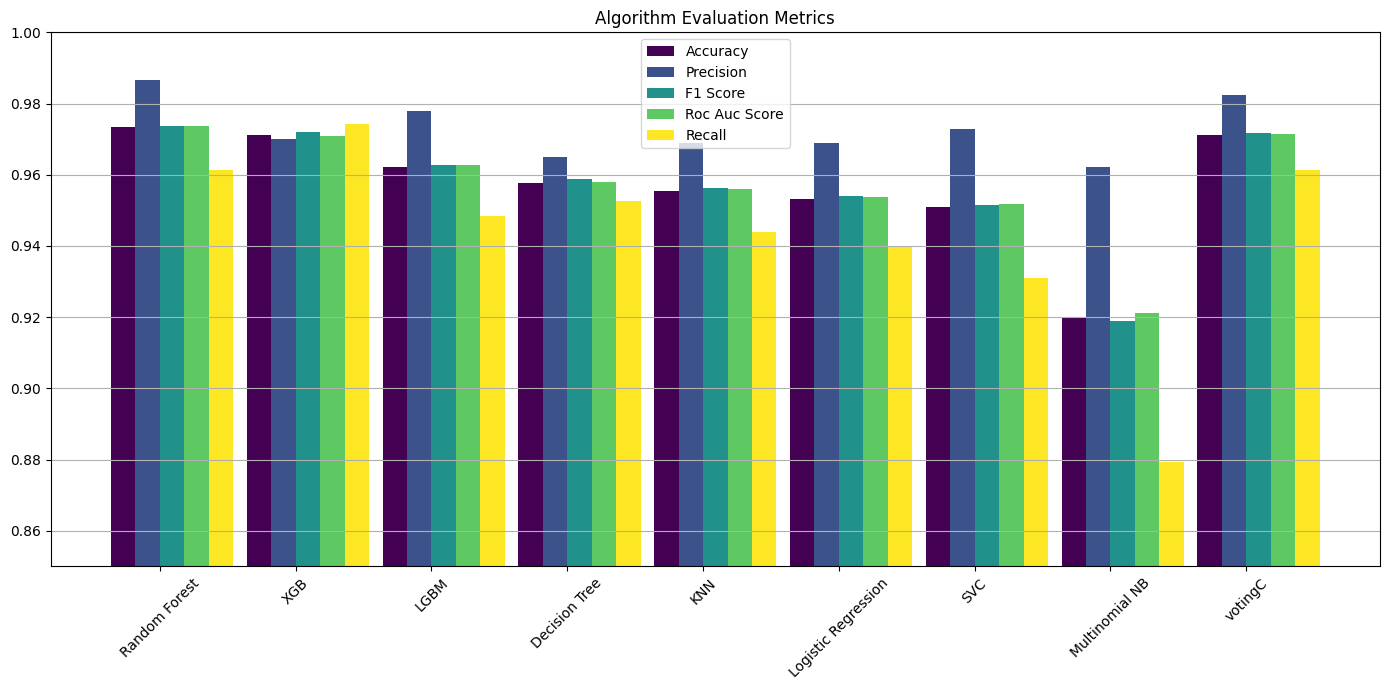

In [118]:
# Number of algorithms

#remove index columnof scores_df
scores_df = scores_df.reset_index(drop=True)

# Getting the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 5))


N = len(scores_df['Algorithm'])

# Indices for bar positions
ind = np.arange(N)

# Width of the bars
width = 0.18

fig, ax = plt.subplots(figsize=(14, 7))

# Bar plots for each metric
p1 = ax.bar(ind, scores_df['Accuracy'], width, label='Accuracy', color=colors[0])
p2 = ax.bar(ind + width, scores_df['Precision'], width, label='Precision', color=colors[1])
p3 = ax.bar(ind + 2 * width, scores_df['F1 Score'], width, label='F1 Score', color=colors[2])
p4 = ax.bar(ind + 3 * width, scores_df['Roc Auc Score'], width, label='Roc Auc Score', color=colors[3])
p5 = ax.bar(ind + 4 * width, scores_df['Recall'], width, label='Recall', color=colors[4])

# Axes and labels
ax.set_title('Algorithm Evaluation Metrics')
ax.set_xticks(ind + 1.5 * width)
ax.set_xticklabels(scores_df['Algorithm'], rotation=45)
ax.set_ylim([0.85, 1.0])
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()

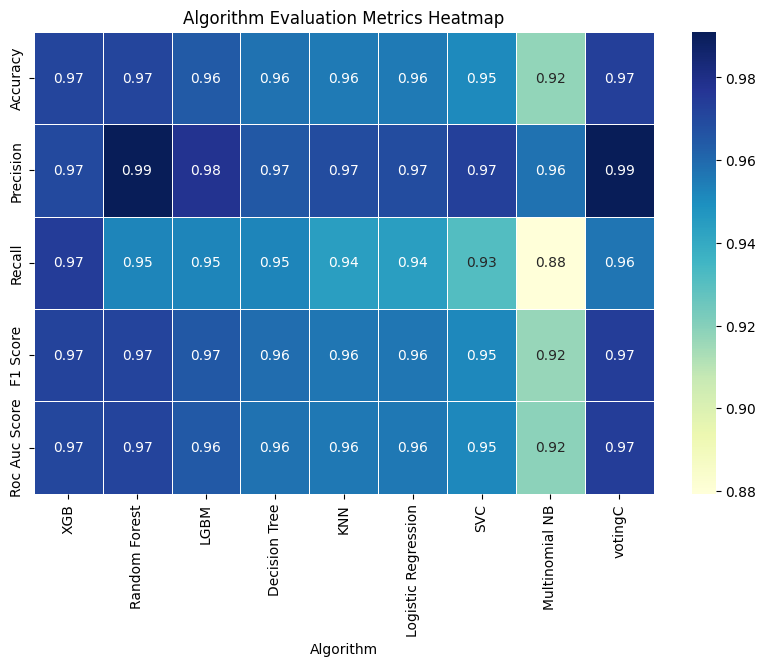

In [52]:

# Heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(scores_df.set_index('Algorithm').T, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Algorithm Evaluation Metrics Heatmap')
plt.show()

In [53]:
#cofusion matrix
cm = confusion_matrix(y_test, vote_pred)
print(cm)

[[215   2]
 [ 10 222]]


In [54]:
print(classification_report(y_test, vote_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       217
           1       0.99      0.96      0.97       232

    accuracy                           0.97       449
   macro avg       0.97      0.97      0.97       449
weighted avg       0.97      0.97      0.97       449



We used following feautures to train the model. 
- num_punctuations	
- num_capitals
- num_numeri
- text_len	

Lets check how to train another model using simple Language Model.

In here we are going to use simple method call TF-IDF

<h1> TF-IDF </h1>

<h2> What is TF-IDF </h2>

<p> TF-IDF stands for "Term Frequency-Inverse Document Frequency." It is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents, often called a corpus. TF-IDF is commonly used in text mining and information retrieval systems to rank documents based on their relevance to a particular query.</p>

Here's a breakdown of the two components:

Term Frequency (TF): This represents the frequency of a word in a document. It is the ratio of the number of times a word appears in a document compared to the total number of words in that document. The idea is that the frequency of a term can be used as a proxy for its importance in the document.

T
 
Inverse Document Frequency (IDF): This represents the importance of a word in the entire corpus. The idea behind IDF is that words that appear frequently in many documents may not contain much informative content (e.g., words like "and", "the", "is"). Thus, the IDF of a term is inversely proportional to the number of documents in which it appears.

Note: The logarithm ensures that low document frequencies are given higher weight.

The TF-IDF score for a term in a particular document is the product of its TF and IDF scores:


Higher TF-IDF scores indicate that a term is important in a given document relative to the entire corpus. This makes TF-IDF useful for tasks such as document classification, clustering, and information retrieval.

In practice, there are variations and refinements to the basic TF-IDF formulation, and many text processing libraries provide built-in methods to compute it. One popular library in Python for this purpose is Scikit-learn.

Example

In [55]:
df

,label,message,bigrams,msg_len,num_punctuations,num_exclamation_marks,num_upper_case,num_numeric,num_sentences,num_words,num_char,text_len,encoded_label
3714,ham,"I am late,so call you tomorrow morning.take ca...","[(i, lateso), (lateso, call), (call, tomorrow)...",92,13,0,1,0,1,21,92,92,0
1311,ham,U r too much close to my heart. If u go away i...,"[(u, r), (r, much), (much, close), (close, hea...",83,3,0,3,0,3,23,83,83,0
548,ham,Wait &lt;#&gt; min..,"[(wait, ltgt), (ltgt, min)]",22,7,0,1,0,1,10,22,22,0
1324,ham,Can you call me plz. Your number shows out of ...,"[(can, call), (call, plz), (plz, your), (your,...",139,5,0,3,1,3,35,139,139,0
3184,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,"[(maybe, if), (if, you), (you, woke), (woke, u...",65,2,0,50,1,1,15,65,65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,"[(want, explicit), (explicit, sex), (sex, 30),...",90,3,1,17,21,3,18,90,90,1
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,"[(asked, 3mobile), (3mobile, if), (if, 0870), ...",160,5,0,104,14,6,38,160,160,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,"[(had, contract), (contract, mobile), (mobile,...",160,8,1,20,2,5,35,160,160,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,"[(reminder, from), (from, o2), (o2, to), (to, ...",147,3,0,14,5,1,30,147,147,1


In [56]:
dataset = "./data/spam_dataset.csv"
df2 = pd.read_csv(dataset, encoding='latin-1')
df2.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df2.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

# Balancing Dataset
# df2 = df2.drop(df2[df2.label == 'ham'].sample(frac=.85, random_state=42).index)
num_spam = target_cat['spam']

# Randomly sampling the majority class to match the count of the minority class
df2 = pd.concat(
    [
        df2[df2['label'] == 'ham'].sample(n=num_spam, random_state=42), 
        df2[df2['label'] == 'spam']
    ]
)


def preprocess_message(message):
    # Remove punctuation
    no_punct = ''.join([char for char in message if char not in string.punctuation])

    #convert to lowercase
    no_punct = no_punct.lower()

    #remove stopwords
    tokens = word_tokenize(no_punct)
    tokens = [word for word in tokens if word not in stop_words]

    #stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in tokens]

    #return cleaned text
    return ' '.join(stemmed)


df2["processed_text"] = df2["message"].apply(preprocess_message)




# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_features=5000, stop_words='english', norm="l2", ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df2['processed_text'])
y = df2['label'].map({'ham': 0, 'spam': 1}).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


# Target variable

# 3. Train/Test Split

X_train.shape, X_test.shape, X_test.shape, y_test.shape

((1195, 5000), (299, 5000), (299, 5000), (299,))

In [57]:
acc_s = []
pre_s = []
rec_s = []
f1_s = []
auc_s = []


for name, model in models.items():
    accuracy, precision, recall, f1, auc = train_clf(model, X_train, y_train, X_test, y_test)

    acc_s.append(accuracy)
    pre_s.append(precision)
    rec_s.append(recall)
    f1_s.append(f1)
    auc_s.append(auc)


scores_df = pd.DataFrame({
    "Algorithm": list(models.keys()),
    "Accuracy": acc_s,
    "Precision": pre_s,
    "Recall": rec_s, 
    "F1 Score": f1_s,
    "Roc Auc Score": auc_s
}).sort_values(by="F1 Score", ascending=False)

[LightGBM] [Info] Number of positive: 593, number of negative: 602
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 1195, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496234 -> initscore=-0.015063
[LightGBM] [Info] Start training from score -0.015063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [58]:
scores_df


,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
3,SVC,0.929766,0.971631,0.889610,0.928814,0.931012
0,Random Forest,0.926421,1.000000,0.857143,0.923077,0.928571
6,Multinomial NB,0.923077,0.964539,0.883117,0.922034,0.924317
2,Logistic Regression,0.923077,0.971223,0.876623,0.921502,0.924519
5,XGB,0.913043,0.944444,0.883117,0.912752,0.913972
1,Decision Tree,0.879599,0.915493,0.844156,0.878378,0.880699
7,LGBM,0.882943,0.954198,0.811688,0.877193,0.885155
4,KNN,0.585284,1.000000,0.194805,0.326087,0.597403


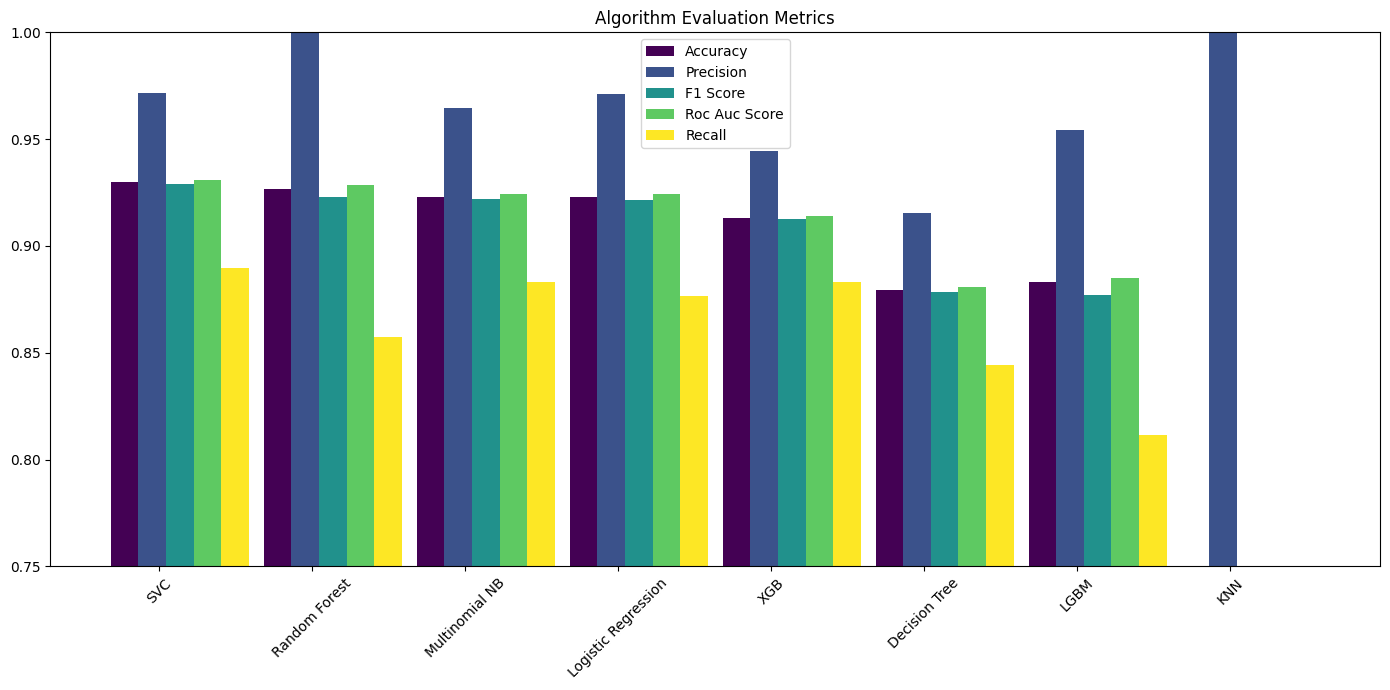

In [59]:
# Number of algorithms

#remove index columnof scores_df
scores_df = scores_df.reset_index(drop=True)

# Getting the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 5))


N = len(scores_df['Algorithm'])

# Indices for bar positions
ind = np.arange(N)

# Width of the bars
width = 0.18

fig, ax = plt.subplots(figsize=(14, 7))

# Bar plots for each metric
p1 = ax.bar(ind, scores_df['Accuracy'], width, label='Accuracy', color=colors[0])
p2 = ax.bar(ind + width, scores_df['Precision'], width, label='Precision', color=colors[1])
p3 = ax.bar(ind + 2 * width, scores_df['F1 Score'], width, label='F1 Score', color=colors[2])
p4 = ax.bar(ind + 3 * width, scores_df['Roc Auc Score'], width, label='Roc Auc Score', color=colors[3])
p5 = ax.bar(ind + 4 * width, scores_df['Recall'], width, label='Recall', color=colors[4])

# Axes and labels
ax.set_title('Algorithm Evaluation Metrics')
ax.set_xticks(ind + 1.25 * width)
ax.set_xticklabels(scores_df['Algorithm'], rotation=45)
ax.set_ylim([0.75, 1.0])
ax.legend()

plt.tight_layout()
plt.show()


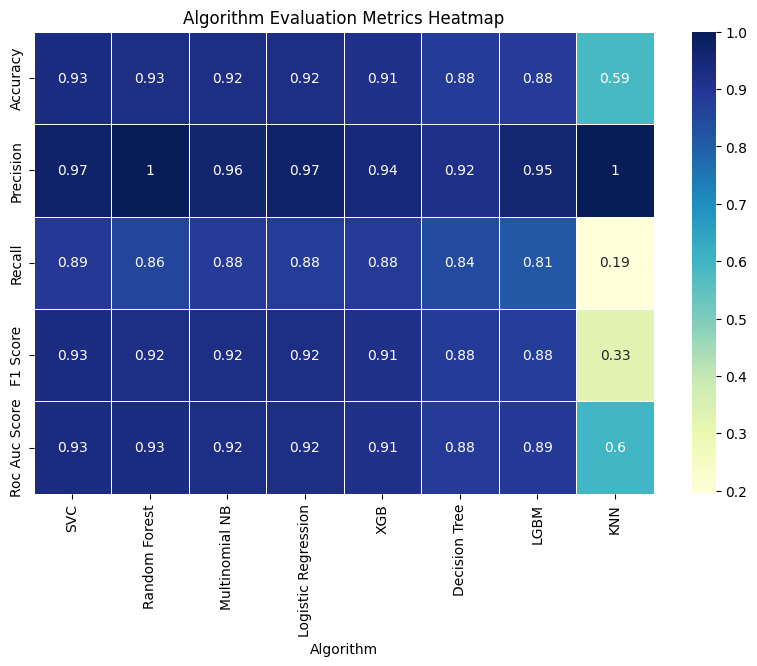

In [60]:
plt.figure(figsize=(10, 6))
sns.heatmap(scores_df.set_index('Algorithm').T, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Algorithm Evaluation Metrics Heatmap')
plt.show()


In [61]:

rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
lrc = LogisticRegression(random_state=42)
svc_c = SVC(kernel="linear", random_state=42, probability=True)
xgb = XGBClassifier(objective='binary:hinge',random_state=42)


rfc.fit(X_train, y_train)
lrc.fit(X_train, y_train)
svc_c.fit(X_train, y_train)
xgb.fit(X_train, y_train)


votingC = VotingClassifier(estimators=[
    ('Random Forest', rfc),
    ('Logistic Regression', lrc),
    ('SVC',svc_c),
    ("XGB",xgb),
    ],
    # voting='soft'
)

votingC = votingC.fit(X_train, y_train)

vote_pred = votingC.predict(X_test)

accuracy = accuracy_score(y_test, vote_pred)
precision = precision_score(y_test, vote_pred)
recall = recall_score(y_test, vote_pred)
f1 = f1_score(y_test, vote_pred)
auc = roc_auc_score(y_test, vote_pred)


print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))
print('Roc Auc Score: {:.2f}'.format(auc))

vote_data = {
    "Algorithm": "votingC",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall, 
    "F1 Score": f1,
    "Roc Auc Score": auc
}

Accuracy: 0.93
Precision: 1.00
Recall: 0.86
F1 Score: 0.92
Roc Auc Score: 0.93


In [62]:
# Add the "vote" data using concat
vote_df = pd.DataFrame([vote_data])
scores_df = pd.concat([scores_df, vote_df], ignore_index=True)

scores_df


,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
0,SVC,0.929766,0.971631,0.889610,0.928814,0.931012
1,Random Forest,0.926421,1.000000,0.857143,0.923077,0.928571
2,Multinomial NB,0.923077,0.964539,0.883117,0.922034,0.924317
3,Logistic Regression,0.923077,0.971223,0.876623,0.921502,0.924519
4,XGB,0.913043,0.944444,0.883117,0.912752,0.913972
5,Decision Tree,0.879599,0.915493,0.844156,0.878378,0.880699
6,LGBM,0.882943,0.954198,0.811688,0.877193,0.885155
7,KNN,0.585284,1.000000,0.194805,0.326087,0.597403
8,votingC,0.926421,1.000000,0.857143,0.923077,0.928571


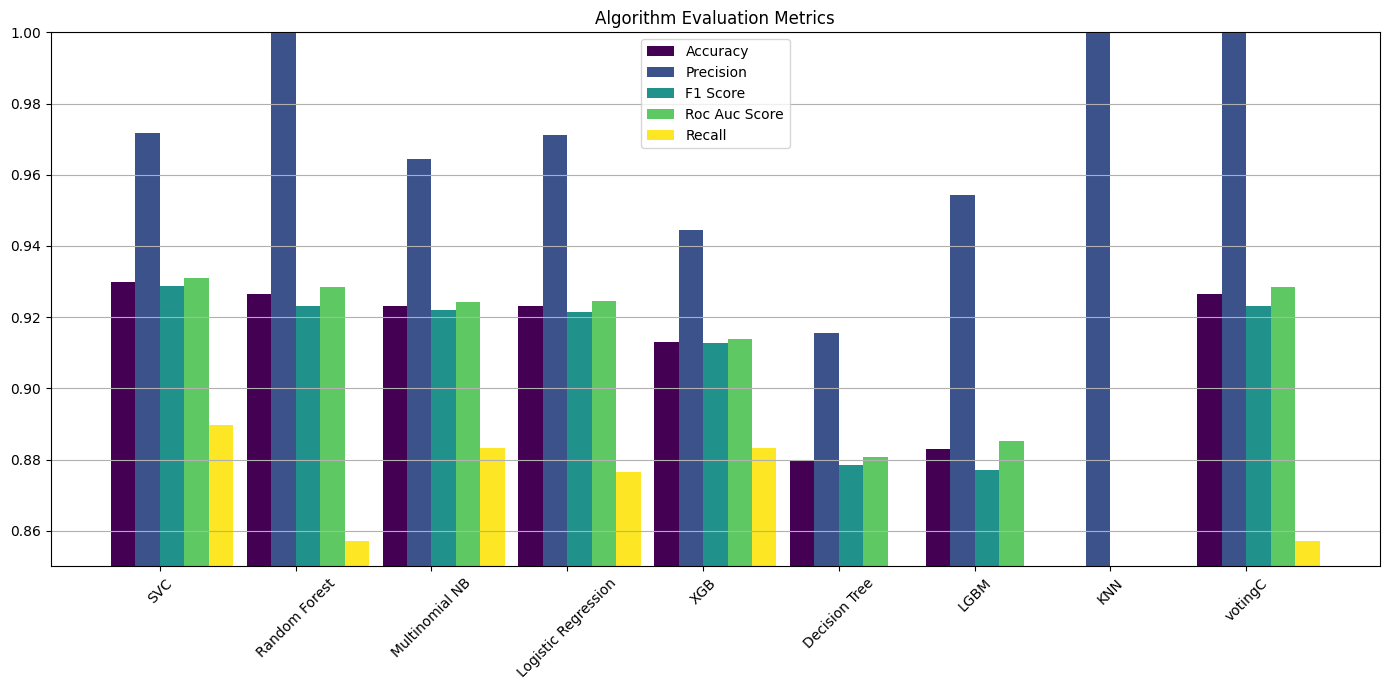

In [63]:

#remove index columnof scores_df
scores_df = scores_df.reset_index(drop=True)

# Getting the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 5))


N = len(scores_df['Algorithm'])

# Indices for bar positions
ind = np.arange(N)

# Width of the bars
width = 0.18

fig, ax = plt.subplots(figsize=(14, 7))

# Bar plots for each metric
p1 = ax.bar(ind, scores_df['Accuracy'], width, label='Accuracy', color=colors[0])
p2 = ax.bar(ind + width, scores_df['Precision'], width, label='Precision', color=colors[1])
p3 = ax.bar(ind + 2 * width, scores_df['F1 Score'], width, label='F1 Score', color=colors[2])
p4 = ax.bar(ind + 3 * width, scores_df['Roc Auc Score'], width, label='Roc Auc Score', color=colors[3])
p5 = ax.bar(ind + 4 * width, scores_df['Recall'], width, label='Recall', color=colors[4])

# Axes and labels
ax.set_title('Algorithm Evaluation Metrics')
ax.set_xticks(ind + 1.5 * width)
ax.set_xticklabels(scores_df['Algorithm'], rotation=45)
ax.set_ylim([0.85, 1.0])
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [64]:
#Compare previous best vs new best

In [65]:
df2

,label,message,processed_text
3714,ham,"I am late,so call you tomorrow morning.take ca...",lateso call tomorrow morningtak care sweet dre...
1311,ham,U r too much close to my heart. If u go away i...,u r much close heart u go away shatter plz stay
548,ham,Wait &lt;#&gt; min..,wait ltgt min
1324,ham,Can you call me plz. Your number shows out of ...,call plz number show coveragd area urgnt call ...
3184,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,mayb woke fuck 3 wouldnt problem
...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,want explicit sex 30 sec ring 02073162414 cost...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,ask 3mobil 0870 chatlin inclu free min india c...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,contract mobil 11 mnth latest motorola nokia e...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,remind o2 get 250 pound free call credit detai...


In [66]:
df

,label,message,bigrams,msg_len,num_punctuations,num_exclamation_marks,num_upper_case,num_numeric,num_sentences,num_words,num_char,text_len,encoded_label
3714,ham,"I am late,so call you tomorrow morning.take ca...","[(i, lateso), (lateso, call), (call, tomorrow)...",92,13,0,1,0,1,21,92,92,0
1311,ham,U r too much close to my heart. If u go away i...,"[(u, r), (r, much), (much, close), (close, hea...",83,3,0,3,0,3,23,83,83,0
548,ham,Wait &lt;#&gt; min..,"[(wait, ltgt), (ltgt, min)]",22,7,0,1,0,1,10,22,22,0
1324,ham,Can you call me plz. Your number shows out of ...,"[(can, call), (call, plz), (plz, your), (your,...",139,5,0,3,1,3,35,139,139,0
3184,ham,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...,"[(maybe, if), (if, you), (you, woke), (woke, u...",65,2,0,50,1,1,15,65,65,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,"[(want, explicit), (explicit, sex), (sex, 30),...",90,3,1,17,21,3,18,90,90,1
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,"[(asked, 3mobile), (3mobile, if), (if, 0870), ...",160,5,0,104,14,6,38,160,160,1
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,"[(had, contract), (contract, mobile), (mobile,...",160,8,1,20,2,5,35,160,160,1
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,"[(reminder, from), (from, o2), (o2, to), (to, ...",147,3,0,14,5,1,30,147,147,1


### combined Model

In [67]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# Scale the numeric features
scaler = StandardScaler()
numeric_features = df[["num_punctuations", "num_upper_case", "num_numeric", "num_words", "num_sentences", "num_char" ]]
numeric_features_scaled = scaler.fit_transform(numeric_features)

# Convert the numeric features to a sparse matrix
numeric_features_sparse = csr_matrix(numeric_features_scaled)

# Concatenate the TF-IDF and numeric features
X_combined = hstack([X_tfidf, numeric_features_sparse])

# Split the combined features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [68]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVC": SVC(kernel="linear", random_state=42),
    "KNN" : KNeighborsClassifier(),
    "XGB": XGBClassifier(objective='binary:hinge', random_state=42),
    # "Multinomial NB": MultinomialNB(),
    "LGBM" : LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=8888)

}



acc_s = []
pre_s = []
rec_s = []
f1_s = []
auc_s = []


for name, model in models.items():
    accuracy, precision, recall, f1, auc = train_clf(model, X_train, y_train, X_test, y_test)

    acc_s.append(accuracy)
    pre_s.append(precision)
    rec_s.append(recall)
    f1_s.append(f1)
    auc_s.append(auc)


scores_df = pd.DataFrame({
    "Algorithm": list(models.keys()),
    "Accuracy": acc_s,
    "Precision": pre_s,
    "Recall": rec_s, 
    "F1 Score": f1_s,
    "Roc Auc Score": auc_s
}).sort_values(by="F1 Score", ascending=False)

[LightGBM] [Info] Number of positive: 593, number of negative: 602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1735
[LightGBM] [Info] Number of data points in the train set: 1195, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496234 -> initscore=-0.015063
[LightGBM] [Info] Start training from score -0.015063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [69]:
scores_df

,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
3,SVC,0.973244,0.986667,0.961039,0.973684,0.973623
6,LGBM,0.969900,0.980132,0.961039,0.970492,0.970175
0,Random Forest,0.966555,1.000000,0.935065,0.966443,0.967532
5,XGB,0.963211,0.986395,0.941558,0.963455,0.963883
1,Decision Tree,0.956522,0.993007,0.922078,0.956229,0.957591
2,Logistic Regression,0.949833,0.966443,0.935065,0.950495,0.950291
4,KNN,0.926421,0.958333,0.896104,0.926174,0.927362


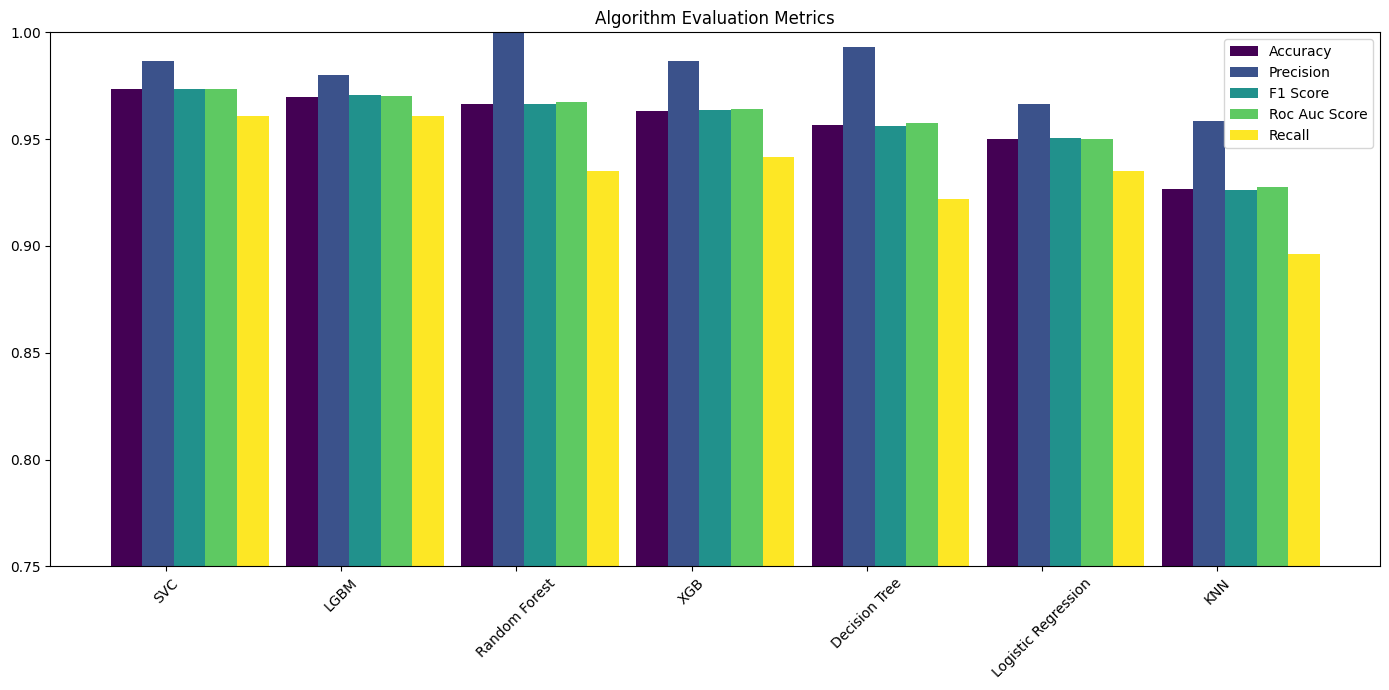

In [70]:
# Number of algorithms

#remove index columnof scores_df
scores_df = scores_df.reset_index(drop=True)

# Getting the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 5))


N = len(scores_df['Algorithm'])

# Indices for bar positions
ind = np.arange(N)

# Width of the bars
width = 0.18

fig, ax = plt.subplots(figsize=(14, 7))

# Bar plots for each metric
p1 = ax.bar(ind, scores_df['Accuracy'], width, label='Accuracy', color=colors[0])
p2 = ax.bar(ind + width, scores_df['Precision'], width, label='Precision', color=colors[1])
p3 = ax.bar(ind + 2 * width, scores_df['F1 Score'], width, label='F1 Score', color=colors[2])
p4 = ax.bar(ind + 3 * width, scores_df['Roc Auc Score'], width, label='Roc Auc Score', color=colors[3])
p5 = ax.bar(ind + 4 * width, scores_df['Recall'], width, label='Recall', color=colors[4])

# Axes and labels
ax.set_title('Algorithm Evaluation Metrics')
ax.set_xticks(ind + 1.25 * width)
ax.set_xticklabels(scores_df['Algorithm'], rotation=45)
ax.set_ylim([0.75, 1.0])
ax.legend()

plt.tight_layout()
plt.show()


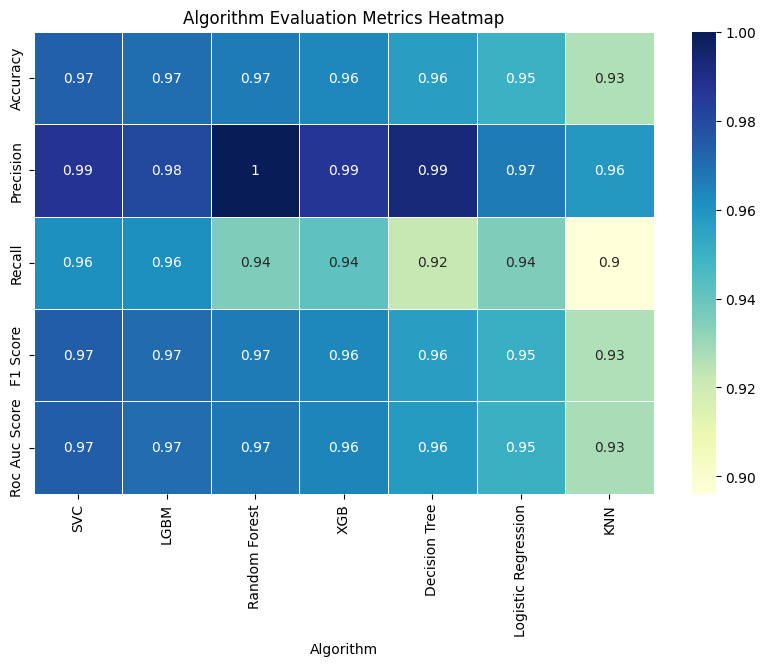

In [71]:
plt.figure(figsize=(10, 6))
sns.heatmap(scores_df.set_index('Algorithm').T, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Algorithm Evaluation Metrics Heatmap')
plt.show()


In [72]:

rfc = RandomForestClassifier(n_estimators=1000, random_state=42)
lrc = LogisticRegression(random_state=42)
svc_c = SVC(kernel="linear", random_state=42, probability=True)
xgb = XGBClassifier(objective='binary:hinge',random_state=42)
lgbm = LGBMClassifier(boosting_type='gbdt',objective='binary',random_state=8888)
dtc = DecisionTreeClassifier(random_state=42)


rfc.fit(X_train, y_train)
lrc.fit(X_train, y_train)
svc_c.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
dtc.fit(X_train, y_train)

votingC = VotingClassifier(estimators=[
    ('Random Forest', rfc),
    ('Logistic Regression', lrc),
    ('SVC',svc_c),
    ("XGB",xgb),
    ("LGBM",lgbm),
    ("Decision Tree",dtc)
    ],
    voting='soft'
)

votingC = votingC.fit(X_train, y_train)

vote_pred = votingC.predict(X_test)

accuracy = accuracy_score(y_test, vote_pred)
precision = precision_score(y_test, vote_pred)
recall = recall_score(y_test, vote_pred)
f1 = f1_score(y_test, vote_pred)
auc = roc_auc_score(y_test, vote_pred)


print('Accuracy: {:.2f}'.format(accuracy))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))
print('Roc Auc Score: {:.2f}'.format(auc))

vote_data = {
    "Algorithm": "votingC",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall, 
    "F1 Score": f1,
    "Roc Auc Score": auc
}

[LightGBM] [Info] Number of positive: 593, number of negative: 602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1735
[LightGBM] [Info] Number of data points in the train set: 1195, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496234 -> initscore=-0.015063
[LightGBM] [Info] Start training from score -0.015063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [73]:
# Add the "vote" data using concat
vote_df = pd.DataFrame([vote_data])
scores_df = pd.concat([scores_df, vote_df], ignore_index=True)

scores_df



,Algorithm,Accuracy,Precision,Recall,F1 Score,Roc Auc Score
0,SVC,0.973244,0.986667,0.961039,0.973684,0.973623
1,LGBM,0.969900,0.980132,0.961039,0.970492,0.970175
2,Random Forest,0.966555,1.000000,0.935065,0.966443,0.967532
3,XGB,0.963211,0.986395,0.941558,0.963455,0.963883
4,Decision Tree,0.956522,0.993007,0.922078,0.956229,0.957591
5,Logistic Regression,0.949833,0.966443,0.935065,0.950495,0.950291
6,KNN,0.926421,0.958333,0.896104,0.926174,0.927362
7,votingC,0.976589,1.000000,0.954545,0.976744,0.977273


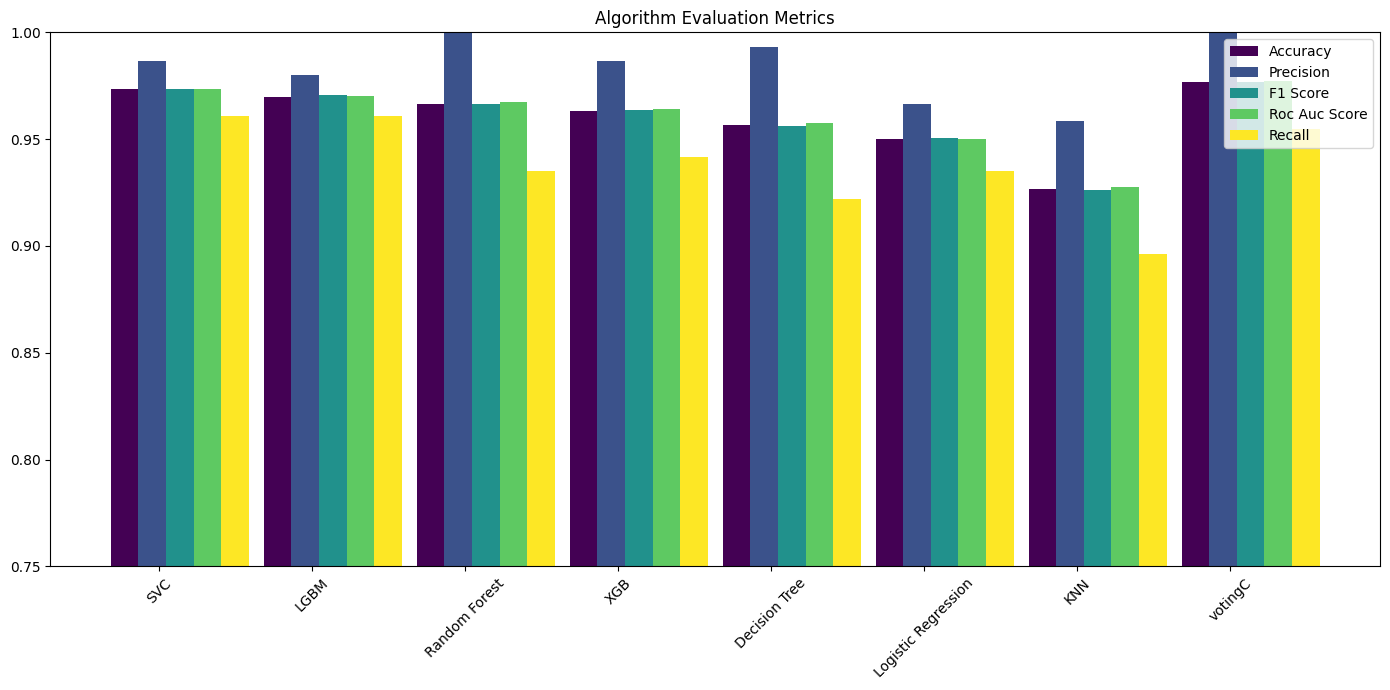

In [74]:
# Number of algorithms

#remove index columnof scores_df
scores_df = scores_df.reset_index(drop=True)

# Getting the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, 5))


N = len(scores_df['Algorithm'])

# Indices for bar positions
ind = np.arange(N)

# Width of the bars
width = 0.18

fig, ax = plt.subplots(figsize=(14, 7))

# Bar plots for each metric
p1 = ax.bar(ind, scores_df['Accuracy'], width, label='Accuracy', color=colors[0])
p2 = ax.bar(ind + width, scores_df['Precision'], width, label='Precision', color=colors[1])
p3 = ax.bar(ind + 2 * width, scores_df['F1 Score'], width, label='F1 Score', color=colors[2])
p4 = ax.bar(ind + 3 * width, scores_df['Roc Auc Score'], width, label='Roc Auc Score', color=colors[3])
p5 = ax.bar(ind + 4 * width, scores_df['Recall'], width, label='Recall', color=colors[4])

# Axes and labels
ax.set_title('Algorithm Evaluation Metrics')
ax.set_xticks(ind + 1.25 * width)
ax.set_xticklabels(scores_df['Algorithm'], rotation=45)
ax.set_ylim([0.75, 1.0])
ax.legend()

plt.tight_layout()
plt.show()


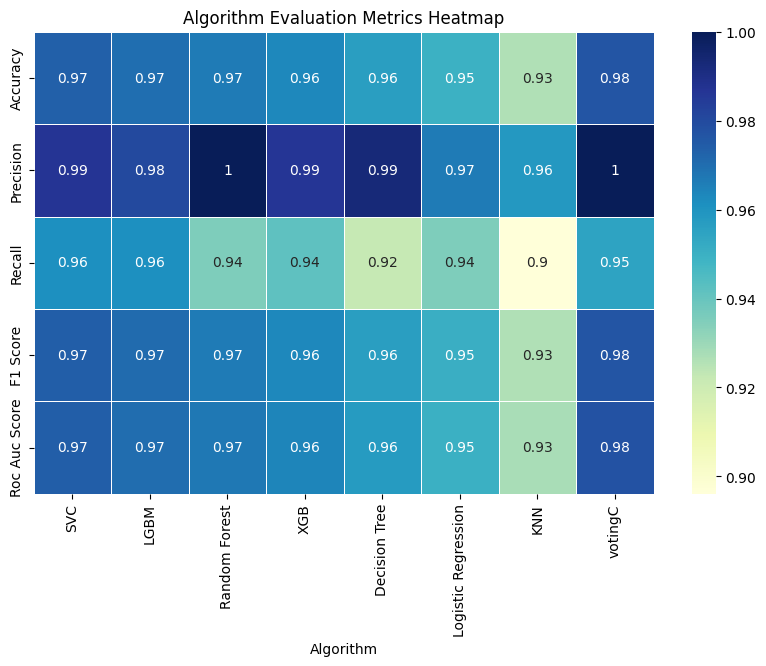

In [75]:
plt.figure(figsize=(10, 6))
sns.heatmap(scores_df.set_index('Algorithm').T, annot=True, cmap='YlGnBu', linewidths=.5)
plt.title('Algorithm Evaluation Metrics Heatmap')
plt.show()


In [76]:
# plot cofusion matrix  for votingC

cm = confusion_matrix(y_test, vote_pred)
print(cm)

[[145   0]
 [  7 147]]


In [77]:
# plot cofusion matrix  for svc
# cm = confusion_matrix(y_test, svc_pred)
